# DSA5103 Assignment 2

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.sparse import random
from pytictoc import TicToc
import math

In [2]:
t = TicToc()

## Q3. LASSO

### (a) generate "design matrix X" and "GT label y"

In [3]:
n, p = 1000, 5000

# fix random seed 519
# Design Matrix X
# each entry samples from Gaussian(0,1)
np.random.seed(519)
X = np.random.randn(n, p)

# for each column, do standardization
X_std = np.zeros((n, p))
mean, std = np.zeros(p), np.zeros(p)
for idx in range(p):
    mean[idx], std[idx] = np.mean(X[:, idx]), np.std(X[:, idx])
    X_std[:, idx] = (X[:, idx] - mean[idx]) / std[idx]

In [4]:
# check the mean and standard deviation for column 0
np.mean(X_std[:,0]), np.std(X_std[:,0]) 

(3.1974423109204506e-17, 1.0)

In [5]:
# sparse ground truth beta
# set random seed
np.random.seed(519)
beta = random(p, 1, density = 0.05)

# random noise
# set random seed
np.random.seed(519)
noise = np.random.randn(n, 1)

# ground-truth label y
y = np.matmul(X_std, beta.A) + 0.01 * noise

In [6]:
y.shape, beta.shape

((1000, 1), (5000, 1))

### (b) 4 optimization algorithms

In [7]:
# general setting

# regularization strength (penalty parameter)
lamb = 0.1 * np.max(abs(np.matmul(X_std.T, y)))

# initialization
beta_init = np.zeros((p,1))

# step length alpha
L = np.max(np.linalg.eig(np.matmul(X_std.T, X_std))[0]).real
alpha = 1/L

# tolerance tol
tol = 1e-3

- Coordinate Descent

In [8]:
beta_cd = np.copy(beta_init)

## at most we iterate for 2000 times
residual_record_cd = np.zeros(2000)
time_record_cd = np.zeros(2000)

## define the soft threshold operator
def soft_threshold(beta, lamb):
    p, _ = beta.shape
    for idx in range(p):
        if beta[idx, 0] >= lamb:
            beta[idx, 0] = beta[idx, 0] - lamb
        elif beta[idx, 0] <= -lamb:
            beta[idx, 0] = beta[idx, 0] + lamb
        else:
            beta[idx, 0] = 0
    return beta

In [9]:
# Coordinate Descent Algorithm
residual = np.linalg.norm(beta_cd - soft_threshold(beta_cd - np.matmul(X_std.T, np.matmul(X_std, beta_cd) - y), lamb), ord=2)

# 0-th iteration
k = 0

residual_record_cd[k], time_record_cd[k] = residual, 0

while residual > tol:
    
    t.tic()
    for i in range(p):
        beta_tmp, X_std_tmp = np.delete(beta_cd, i, axis = 0), np.delete(X_std, i, axis = -1)
        X_std_i = X_std[:, [i]]
        delta = np.matmul(X_std_tmp, beta_tmp) - y
        ## after standardization, square_norm is always 1000
        # square_norm = np.linalg.norm(X_std_i, ord = 2) ** 2
        square_norm = 1000
        # updates
        beta_cd[i] = soft_threshold(-np.matmul(X_std_i.T, delta) / square_norm, lamb/square_norm)
        
    time = t.tocvalue()
    residual = np.linalg.norm(beta_cd - soft_threshold(beta_cd - np.matmul(X_std.T, np.matmul(X_std, beta_cd) - y), lamb), ord=2)
    
    k = k + 1
    residual_record_cd[k], time_record_cd[k] = residual, time + time_record_cd[k-1]
    
    print('Achieving beta({number})'.format(number = k))
    print('Residual for beta({number}) is: {residual}\n'.format(number = k, residual = residual))
    
    # at most we have 2000 iteration
    if k >= 1999:
        break  

Achieving beta(1)
Residual for beta(1) is: 181.3764320993765

Achieving beta(2)
Residual for beta(2) is: 193.60956166749736

Achieving beta(3)
Residual for beta(3) is: 215.87897727853786

Achieving beta(4)
Residual for beta(4) is: 193.82617716351004

Achieving beta(5)
Residual for beta(5) is: 152.68699907944622

Achieving beta(6)
Residual for beta(6) is: 104.24741580635784

Achieving beta(7)
Residual for beta(7) is: 67.66790269763018

Achieving beta(8)
Residual for beta(8) is: 45.269993224157574

Achieving beta(9)
Residual for beta(9) is: 30.948178456485106

Achieving beta(10)
Residual for beta(10) is: 21.245431405861744

Achieving beta(11)
Residual for beta(11) is: 14.118524709826922

Achieving beta(12)
Residual for beta(12) is: 9.535180798964822

Achieving beta(13)
Residual for beta(13) is: 6.482772975285698

Achieving beta(14)
Residual for beta(14) is: 4.467209681588829

Achieving beta(15)
Residual for beta(15) is: 3.105015868884434

Achieving beta(16)
Residual for beta(16) is: 2.17

- Proximal Gradient

In [10]:
beta_pg = np.copy(beta_init)

## at most we iterate for 5000 times
residual_record_pg = np.zeros(5000)
time_record_pg = np.zeros(5000)

In [11]:
# Proximal Gradient Algorithm
residual = np.linalg.norm(beta_pg - soft_threshold(beta_pg - np.matmul(X_std.T, np.matmul(X_std, beta_pg) - y), lamb), ord=2)

# 0-th iteration
k = 0

residual_record_pg[k], time_record_pg[k] = residual, 0

while residual > tol:
    
    t.tic()
    
    delta = np.matmul(X_std, beta_pg) - y
    beta_pg = soft_threshold(beta_pg - alpha * np.matmul(X_std.T, delta), lamb * alpha)
   
    time = t.tocvalue()
    residual = np.linalg.norm(beta_pg - soft_threshold(beta_pg - np.matmul(X_std.T, np.matmul(X_std, beta_pg) - y), lamb), ord=2)
    
    k = k + 1
    residual_record_pg[k], time_record_pg[k] = residual, time + time_record_pg[k-1]
    
    print('Achieving beta({number})'.format(number = k))
    print('Residual for beta({number}) is: {residual}\n'.format(number = k, residual = residual))
    
    # at most we have 5000 iteration
    if k >= 4999:
        break  

Achieving beta(1)
Residual for beta(1) is: 6385.410253923313

Achieving beta(2)
Residual for beta(2) is: 4075.191185042766

Achieving beta(3)
Residual for beta(3) is: 3036.7152811150504

Achieving beta(4)
Residual for beta(4) is: 2462.962292266146

Achieving beta(5)
Residual for beta(5) is: 2096.9213253117655

Achieving beta(6)
Residual for beta(6) is: 1844.544029966479

Achieving beta(7)
Residual for beta(7) is: 1650.8118459756663

Achieving beta(8)
Residual for beta(8) is: 1501.48912426088

Achieving beta(9)
Residual for beta(9) is: 1380.421809541966

Achieving beta(10)
Residual for beta(10) is: 1277.8249777441974

Achieving beta(11)
Residual for beta(11) is: 1191.8161846939847

Achieving beta(12)
Residual for beta(12) is: 1112.6930338864643

Achieving beta(13)
Residual for beta(13) is: 1041.4795643917332

Achieving beta(14)
Residual for beta(14) is: 977.9249382453954

Achieving beta(15)
Residual for beta(15) is: 924.6890395577948

Achieving beta(16)
Residual for beta(16) is: 878.869

Achieving beta(144)
Residual for beta(144) is: 37.499146591138825

Achieving beta(145)
Residual for beta(145) is: 36.821018332559916

Achieving beta(146)
Residual for beta(146) is: 36.16534038290417

Achieving beta(147)
Residual for beta(147) is: 35.52937143074781

Achieving beta(148)
Residual for beta(148) is: 34.911014384583694

Achieving beta(149)
Residual for beta(149) is: 34.30787564392265

Achieving beta(150)
Residual for beta(150) is: 33.70952407964428

Achieving beta(151)
Residual for beta(151) is: 33.12104342167128

Achieving beta(152)
Residual for beta(152) is: 32.53594510079386

Achieving beta(153)
Residual for beta(153) is: 31.9530974545714

Achieving beta(154)
Residual for beta(154) is: 31.378844082566303

Achieving beta(155)
Residual for beta(155) is: 30.820030327124158

Achieving beta(156)
Residual for beta(156) is: 30.275476365895564

Achieving beta(157)
Residual for beta(157) is: 29.744197901395065

Achieving beta(158)
Residual for beta(158) is: 29.223164265212134

Ach

Achieving beta(270)
Residual for beta(270) is: 4.277337804580777

Achieving beta(271)
Residual for beta(271) is: 4.209463921028723

Achieving beta(272)
Residual for beta(272) is: 4.142931830519823

Achieving beta(273)
Residual for beta(273) is: 4.077600524416931

Achieving beta(274)
Residual for beta(274) is: 4.013530462821193

Achieving beta(275)
Residual for beta(275) is: 3.9506743891003193

Achieving beta(276)
Residual for beta(276) is: 3.888990974450939

Achieving beta(277)
Residual for beta(277) is: 3.828434525372204

Achieving beta(278)
Residual for beta(278) is: 3.768968607463229

Achieving beta(279)
Residual for beta(279) is: 3.7105707739781564

Achieving beta(280)
Residual for beta(280) is: 3.65323107498981

Achieving beta(281)
Residual for beta(281) is: 3.5968226113495696

Achieving beta(282)
Residual for beta(282) is: 3.5414241678277767

Achieving beta(283)
Residual for beta(283) is: 3.4870210074283463

Achieving beta(284)
Residual for beta(284) is: 3.433593998590626

Achiev

Achieving beta(397)
Residual for beta(397) is: 0.6320800626228311

Achieving beta(398)
Residual for beta(398) is: 0.6226526191148857

Achieving beta(399)
Residual for beta(399) is: 0.6133931933321289

Achieving beta(400)
Residual for beta(400) is: 0.6042980724418309

Achieving beta(401)
Residual for beta(401) is: 0.5953244315910802

Achieving beta(402)
Residual for beta(402) is: 0.5864885797707955

Achieving beta(403)
Residual for beta(403) is: 0.5777143253694412

Achieving beta(404)
Residual for beta(404) is: 0.5690085235384307

Achieving beta(405)
Residual for beta(405) is: 0.5604005123270359

Achieving beta(406)
Residual for beta(406) is: 0.5518069189057766

Achieving beta(407)
Residual for beta(407) is: 0.5433501085605867

Achieving beta(408)
Residual for beta(408) is: 0.534989004539688

Achieving beta(409)
Residual for beta(409) is: 0.5267522765525323

Achieving beta(410)
Residual for beta(410) is: 0.5186556106910049

Achieving beta(411)
Residual for beta(411) is: 0.51065414178858

Achieving beta(523)
Residual for beta(523) is: 0.08666852036368423

Achieving beta(524)
Residual for beta(524) is: 0.08529499892164841

Achieving beta(525)
Residual for beta(525) is: 0.08394341196917843

Achieving beta(526)
Residual for beta(526) is: 0.08261340740840245

Achieving beta(527)
Residual for beta(527) is: 0.08130463885565635

Achieving beta(528)
Residual for beta(528) is: 0.08001676555062741

Achieving beta(529)
Residual for beta(529) is: 0.07874945226111148

Achieving beta(530)
Residual for beta(530) is: 0.07750236919502872

Achieving beta(531)
Residual for beta(531) is: 0.07627519191018087

Achieving beta(532)
Residual for beta(532) is: 0.07506760122612856

Achieving beta(533)
Residual for beta(533) is: 0.07387928313787107

Achieving beta(534)
Residual for beta(534) is: 0.07270992873462173

Achieving beta(535)
Residual for beta(535) is: 0.07155923410942334

Achieving beta(536)
Residual for beta(536) is: 0.07042690028478737

Achieving beta(537)
Residual for beta(537) is: 0

Achieving beta(645)
Residual for beta(645) is: 0.012500700744437416

Achieving beta(646)
Residual for beta(646) is: 0.012304499348885918

Achieving beta(647)
Residual for beta(647) is: 0.012111398233308538

Achieving beta(648)
Residual for beta(648) is: 0.011921348374778698

Achieving beta(649)
Residual for beta(649) is: 0.011734301531103476

Achieving beta(650)
Residual for beta(650) is: 0.0115502102296162

Achieving beta(651)
Residual for beta(651) is: 0.011369027754519466

Achieving beta(652)
Residual for beta(652) is: 0.011190708134983681

Achieving beta(653)
Residual for beta(653) is: 0.011015206134523003

Achieving beta(654)
Residual for beta(654) is: 0.010842477236042364

Achieving beta(655)
Residual for beta(655) is: 0.010672477633695042

Achieving beta(656)
Residual for beta(656) is: 0.010505164218811657

Achieving beta(657)
Residual for beta(657) is: 0.010340494571409889

Achieving beta(658)
Residual for beta(658) is: 0.01017842694669154

Achieving beta(659)
Residual for beta

Achieving beta(764)
Residual for beta(764) is: 0.001907404492224349

Achieving beta(765)
Residual for beta(765) is: 0.0018775621560769167

Achieving beta(766)
Residual for beta(766) is: 0.0018481877077016322

Achieving beta(767)
Residual for beta(767) is: 0.0018192737932849392

Achieving beta(768)
Residual for beta(768) is: 0.001790813172984363

Achieving beta(769)
Residual for beta(769) is: 0.0017627987223224175

Achieving beta(770)
Residual for beta(770) is: 0.0017352234296659972

Achieving beta(771)
Residual for beta(771) is: 0.0017080803919699986

Achieving beta(772)
Residual for beta(772) is: 0.001681362816532276

Achieving beta(773)
Residual for beta(773) is: 0.0016550640168365271

Achieving beta(774)
Residual for beta(774) is: 0.0016291774129272964

Achieving beta(775)
Residual for beta(775) is: 0.001603696528019898

Achieving beta(776)
Residual for beta(776) is: 0.0015786149869719737

Achieving beta(777)
Residual for beta(777) is: 0.001553926515463747

Achieving beta(778)
Resid

- Accelarated Proxiaml Gradient

In [12]:
# record beta_k-1
beta_apg_old = np.copy(beta_init)
# record beta_k
beta_apg_new = np.copy(beta_init)

## at most we iterate for 5000 times
residual_record_apg = np.zeros(5000)
time_record_apg = np.zeros(5000)

# record the momentum coefficient t
tk = [1, 1]

In [13]:
# Accelarated PG Algorithm
residual = np.linalg.norm(beta_apg_new - soft_threshold(beta_apg_new - np.matmul(X_std.T, np.matmul(X_std, beta_apg_new) - y), lamb), ord=2)

# 0-th iteration
k = 0

residual_record_apg[k], time_record_apg[k] = residual, 0

while residual > tol:
    
    t.tic()
    if k == 0:
        hat_beta_apg = beta_apg_new
    else:
        hat_beta_apg = beta_apg_new + (tk[0] - 1)/ tk[1] * (beta_apg_new - beta_apg_old)
        
    
    delta = np.matmul(X_std, hat_beta_apg) - y
    beta_apg_old = beta_apg_new
    beta_apg_new = soft_threshold(hat_beta_apg - alpha * np.matmul(X_std.T, delta), lamb * alpha)
   
    time = t.tocvalue()
    
    residual = np.linalg.norm(beta_apg_new - soft_threshold(beta_apg_new - np.matmul(X_std.T, np.matmul(X_std, beta_apg_new) - y), lamb), ord=2)
    
    k = k + 1
    residual_record_apg[k], time_record_apg[k] = residual, time + time_record_apg[k-1]
    
    print('Achieving beta({number})'.format(number = k))
    print('Residual for beta({number}) is: {residual}\n'.format(number = k, residual = residual))
    
    # update t
    tk[0], tk[1] = tk[1], (1 + math.sqrt(1 + 4 * (tk[1]**2) )) / 2
    
    # at most we have 5000 iteration
    if k >= 4999:
        break  

Achieving beta(1)
Residual for beta(1) is: 6385.410253923313

Achieving beta(2)
Residual for beta(2) is: 4075.191185042766

Achieving beta(3)
Residual for beta(3) is: 2749.9218337601997

Achieving beta(4)
Residual for beta(4) is: 1983.0269326272687

Achieving beta(5)
Residual for beta(5) is: 1517.359390506045

Achieving beta(6)
Residual for beta(6) is: 1208.729325489333

Achieving beta(7)
Residual for beta(7) is: 990.3344371776071

Achieving beta(8)
Residual for beta(8) is: 811.4246070332865

Achieving beta(9)
Residual for beta(9) is: 676.8039920315889

Achieving beta(10)
Residual for beta(10) is: 576.7424844830061

Achieving beta(11)
Residual for beta(11) is: 499.00804206242077

Achieving beta(12)
Residual for beta(12) is: 430.41524326327703

Achieving beta(13)
Residual for beta(13) is: 373.3774337725907

Achieving beta(14)
Residual for beta(14) is: 323.8683407737654

Achieving beta(15)
Residual for beta(15) is: 280.8165507176303

Achieving beta(16)
Residual for beta(16) is: 240.58294

Achieving beta(128)
Residual for beta(128) is: 2.0452256068431884

Achieving beta(129)
Residual for beta(129) is: 1.9502236137949727

Achieving beta(130)
Residual for beta(130) is: 1.880867346783224

Achieving beta(131)
Residual for beta(131) is: 1.8536874651786677

Achieving beta(132)
Residual for beta(132) is: 1.8589490883517927

Achieving beta(133)
Residual for beta(133) is: 1.8899466441123645

Achieving beta(134)
Residual for beta(134) is: 1.9286806016419695

Achieving beta(135)
Residual for beta(135) is: 1.9733928966844119

Achieving beta(136)
Residual for beta(136) is: 2.02006650172135

Achieving beta(137)
Residual for beta(137) is: 2.0672737969173447

Achieving beta(138)
Residual for beta(138) is: 2.1130490123084753

Achieving beta(139)
Residual for beta(139) is: 2.1532937901641347

Achieving beta(140)
Residual for beta(140) is: 2.1806201120205455

Achieving beta(141)
Residual for beta(141) is: 2.1913916122905186

Achieving beta(142)
Residual for beta(142) is: 2.187582802522889


Achieving beta(252)
Residual for beta(252) is: 0.31699947046158433

Achieving beta(253)
Residual for beta(253) is: 0.290179804053383

Achieving beta(254)
Residual for beta(254) is: 0.2633815868238725

Achieving beta(255)
Residual for beta(255) is: 0.23794902700189188

Achieving beta(256)
Residual for beta(256) is: 0.2156945691587271

Achieving beta(257)
Residual for beta(257) is: 0.19853694658345852

Achieving beta(258)
Residual for beta(258) is: 0.1882044621611543

Achieving beta(259)
Residual for beta(259) is: 0.185498577208194

Achieving beta(260)
Residual for beta(260) is: 0.1902741607187536

Achieving beta(261)
Residual for beta(261) is: 0.20097670403238807

Achieving beta(262)
Residual for beta(262) is: 0.21549284624407603

Achieving beta(263)
Residual for beta(263) is: 0.23214028604654577

Achieving beta(264)
Residual for beta(264) is: 0.24924466272340512

Achieving beta(265)
Residual for beta(265) is: 0.2654790178853314

Achieving beta(266)
Residual for beta(266) is: 0.27973118

Achieving beta(375)
Residual for beta(375) is: 0.0726385889409018

Achieving beta(376)
Residual for beta(376) is: 0.0670020663137602

Achieving beta(377)
Residual for beta(377) is: 0.060856586687019404

Achieving beta(378)
Residual for beta(378) is: 0.05442329764044308

Achieving beta(379)
Residual for beta(379) is: 0.04798144914936655

Achieving beta(380)
Residual for beta(380) is: 0.041893974678595104

Achieving beta(381)
Residual for beta(381) is: 0.036644613154195455

Achieving beta(382)
Residual for beta(382) is: 0.03284352556990625

Achieving beta(383)
Residual for beta(383) is: 0.031023766409340153

Achieving beta(384)
Residual for beta(384) is: 0.03151114438233607

Achieving beta(385)
Residual for beta(385) is: 0.034019529784001676

Achieving beta(386)
Residual for beta(386) is: 0.03780663443768562

Achieving beta(387)
Residual for beta(387) is: 0.04225475079641579

Achieving beta(388)
Residual for beta(388) is: 0.04685103634294716

Achieving beta(389)
Residual for beta(389) is

Achieving beta(501)
Residual for beta(501) is: 0.016532948774754475

Achieving beta(502)
Residual for beta(502) is: 0.015528046801884984

Achieving beta(503)
Residual for beta(503) is: 0.014440676677114881

Achieving beta(504)
Residual for beta(504) is: 0.013314468740483209

Achieving beta(505)
Residual for beta(505) is: 0.01220219304000622

Achieving beta(506)
Residual for beta(506) is: 0.011166882476176943

Achieving beta(507)
Residual for beta(507) is: 0.010280970118716199

Achieving beta(508)
Residual for beta(508) is: 0.009619869363059615

Achieving beta(509)
Residual for beta(509) is: 0.009247061432997097

Achieving beta(510)
Residual for beta(510) is: 0.009193018944777276

Achieving beta(511)
Residual for beta(511) is: 0.00943945370200397

Achieving beta(512)
Residual for beta(512) is: 0.009925908079831673

Achieving beta(513)
Residual for beta(513) is: 0.010571751272410605

Achieving beta(514)
Residual for beta(514) is: 0.01129725587722813

Achieving beta(515)
Residual for beta

Achieving beta(626)
Residual for beta(626) is: 0.004568664904846188

Achieving beta(627)
Residual for beta(627) is: 0.0043981626830668485

Achieving beta(628)
Residual for beta(628) is: 0.004193931132106503

Achieving beta(629)
Residual for beta(629) is: 0.003962924031781324

Achieving beta(630)
Residual for beta(630) is: 0.0037137011771597125

Achieving beta(631)
Residual for beta(631) is: 0.0034566054850911723

Achieving beta(632)
Residual for beta(632) is: 0.0032039390108650357

Achieving beta(633)
Residual for beta(633) is: 0.002969978516556236

Achieving beta(634)
Residual for beta(634) is: 0.0027704807644887744

Achieving beta(635)
Residual for beta(635) is: 0.002621136917832895

Achieving beta(636)
Residual for beta(636) is: 0.002534608063768969

Achieving beta(637)
Residual for beta(637) is: 0.002516808923440658

Achieving beta(638)
Residual for beta(638) is: 0.0025645362100469382

Achieving beta(639)
Residual for beta(639) is: 0.002666339478122798

Achieving beta(640)
Residual

- APG-restart

In [14]:
# record beta_k-1
beta_apg_old_restart = np.copy(beta_init)
# record beta_k
beta_apg_new_restart = np.copy(beta_init)

## at most we iterate for 5000 times
residual_record_apg_restart = np.zeros(5000)
time_record_apg_restart = np.zeros(5000)

# record the momentum coefficient t
tk = [1, 1]

# restart time point
trigger = 0
restart = 100

In [15]:
# Accelarated PG Algorithm - restart
residual = np.linalg.norm(beta_apg_new_restart - soft_threshold(beta_apg_new_restart - np.matmul(X_std.T, np.matmul(X_std, beta_apg_new_restart) - y), lamb), ord=2)

# 0-th iteration
k = 0

residual_record_apg_restart[k], time_record_apg_restart[k] = residual, 0

while residual > tol:
    
    t.tic()
    if trigger == 0:
        hat_beta_apg_restart = beta_apg_new_restart
    else:
        hat_beta_apg_restart = beta_apg_new_restart + (tk[0] - 1)/ tk[1] * (beta_apg_new_restart - beta_apg_old_restart)
        
    
    delta = np.matmul(X_std, hat_beta_apg_restart) - y
    beta_apg_old_restart = beta_apg_new_restart
    beta_apg_new_restart = soft_threshold(hat_beta_apg_restart - alpha * np.matmul(X_std.T, delta), lamb * alpha)
   
    time = t.tocvalue()
    
    residual = np.linalg.norm(beta_apg_new_restart - soft_threshold(beta_apg_new_restart - np.matmul(X_std.T, np.matmul(X_std, beta_apg_new_restart) - y), lamb), ord=2)
    
    k = k + 1    
    residual_record_apg_restart[k], time_record_apg_restart[k] = residual, time + time_record_apg_restart[k-1]
    
    print('Achieving beta({number})'.format(number = k))
    print('Residual for beta({number}) is: {residual}\n'.format(number = k, residual = residual))
    
    trigger = trigger + 1
    # restart
    if trigger == restart:
        tk[0], tk[1] = 1, 1
        # reset trigger
        trigger = 0
    else:
        # update t
        tk[0], tk[1] = tk[1], (1 + math.sqrt(1 + 4 * (tk[1]**2) )) / 2
    
    # at most we have 5000 iteration
    if k >= 4999:
        break  

Achieving beta(1)
Residual for beta(1) is: 6385.410253923313

Achieving beta(2)
Residual for beta(2) is: 4075.191185042766

Achieving beta(3)
Residual for beta(3) is: 2749.9218337601997

Achieving beta(4)
Residual for beta(4) is: 1983.0269326272687

Achieving beta(5)
Residual for beta(5) is: 1517.359390506045

Achieving beta(6)
Residual for beta(6) is: 1208.729325489333

Achieving beta(7)
Residual for beta(7) is: 990.3344371776071

Achieving beta(8)
Residual for beta(8) is: 811.4246070332865

Achieving beta(9)
Residual for beta(9) is: 676.8039920315889

Achieving beta(10)
Residual for beta(10) is: 576.7424844830061

Achieving beta(11)
Residual for beta(11) is: 499.00804206242077

Achieving beta(12)
Residual for beta(12) is: 430.41524326327703

Achieving beta(13)
Residual for beta(13) is: 373.3774337725907

Achieving beta(14)
Residual for beta(14) is: 323.8683407737654

Achieving beta(15)
Residual for beta(15) is: 280.8165507176303

Achieving beta(16)
Residual for beta(16) is: 240.58294

Achieving beta(135)
Residual for beta(135) is: 0.3878649655708054

Achieving beta(136)
Residual for beta(136) is: 0.39819213844638274

Achieving beta(137)
Residual for beta(137) is: 0.40366169955693343

Achieving beta(138)
Residual for beta(138) is: 0.4041705988695206

Achieving beta(139)
Residual for beta(139) is: 0.3996937940442911

Achieving beta(140)
Residual for beta(140) is: 0.3908361465809817

Achieving beta(141)
Residual for beta(141) is: 0.3781364737698954

Achieving beta(142)
Residual for beta(142) is: 0.36192202109095106

Achieving beta(143)
Residual for beta(143) is: 0.3425540597517687

Achieving beta(144)
Residual for beta(144) is: 0.3204796061801499

Achieving beta(145)
Residual for beta(145) is: 0.2961958833589349

Achieving beta(146)
Residual for beta(146) is: 0.2703494220238677

Achieving beta(147)
Residual for beta(147) is: 0.24382659570382273

Achieving beta(148)
Residual for beta(148) is: 0.21705548744762632

Achieving beta(149)
Residual for beta(149) is: 0.19075524

### (c) plot log10(residual) v.s. iteration number 

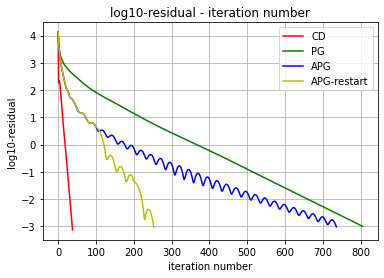

In [16]:
plt.figure(1)
plt.plot(np.log10(residual_record_cd[residual_record_cd!=0]), color = 'r')
plt.plot(np.log10(residual_record_pg[residual_record_pg!=0]), color = 'g')
plt.plot(np.log10(residual_record_apg[residual_record_apg!=0]), color = 'b')
plt.plot(np.log10(residual_record_apg_restart[residual_record_apg_restart!=0]), color ='y')

plt.xlabel('iteration number')
plt.ylabel('log10-residual')
plt.grid()
plt.title('log10-residual - iteration number')

plt.legend(['CD', 'PG', 'APG', 'APG-restart'])
plt.show()

### (d) plot log10(residual) v.s. running time

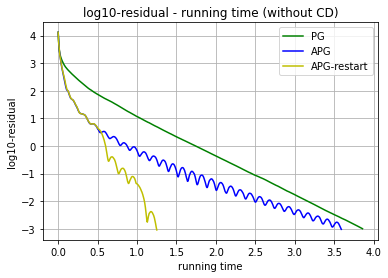

In [17]:
plt.figure(1)
#plt.plot(time_record_cd[residual_record_cd!=0], np.log10(residual_record_cd[residual_record_cd!=0]), color = 'r')
plt.plot(time_record_pg[residual_record_pg!=0], np.log10(residual_record_pg[residual_record_pg!=0]), color = 'g')
plt.plot(time_record_apg[residual_record_apg!=0], np.log10(residual_record_apg[residual_record_apg!=0]), color = 'b')
plt.plot(time_record_apg_restart[residual_record_apg_restart!=0], np.log10(residual_record_apg_restart[residual_record_apg_restart!=0]), color ='y')

plt.xlabel('running time')
plt.ylabel('log10-residual')
plt.grid()
plt.title('log10-residual - running time (without CD)')

plt.legend(['PG', 'APG', 'APG-restart'])
plt.show()

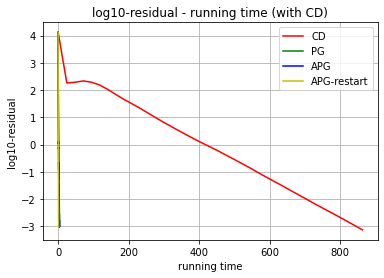

In [18]:
plt.figure(1)
plt.plot(time_record_cd[residual_record_cd!=0], np.log10(residual_record_cd[residual_record_cd!=0]), color = 'r')
plt.plot(time_record_pg[residual_record_pg!=0], np.log10(residual_record_pg[residual_record_pg!=0]), color = 'g')
plt.plot(time_record_apg[residual_record_apg!=0], np.log10(residual_record_apg[residual_record_apg!=0]), color = 'b')
plt.plot(time_record_apg_restart[residual_record_apg_restart!=0], np.log10(residual_record_apg_restart[residual_record_apg_restart!=0]), color ='y')

plt.xlabel('running time')
plt.ylabel('log10-residual')
plt.grid()
plt.title('log10-residual - running time (with CD)')

plt.legend(['CD', 'PG', 'APG', 'APG-restart'])
plt.show()

### (e) APG, APG-restart comparison
- max iteration = 3000
- tolerance = 1e-10

In [19]:
tol_comp = 1e-10
max_iter = 3000

- APG

In [20]:
# record beta_k-1
beta_apg_old = np.copy(beta_init)
# record beta_k
beta_apg_new = np.copy(beta_init)

## at most we iterate for 3000 times
residual_record_apg = np.zeros(max_iter)
time_record_apg = np.zeros(max_iter)

# record the momentum coefficient t
tk = [1, 1]

# Accelarated PG Algorithm
residual = np.linalg.norm(beta_apg_new - soft_threshold(beta_apg_new - np.matmul(X_std.T, np.matmul(X_std, beta_apg_new) - y), lamb), ord=2)

# 0-th iteration
k = 0

residual_record_apg[k], time_record_apg[k] = residual, 0

while residual > tol_comp:
    
    t.tic()
    if k == 0:
        hat_beta_apg = beta_apg_new
    else:
        hat_beta_apg = beta_apg_new + (tk[0] - 1)/ tk[1] * (beta_apg_new - beta_apg_old)
        
    
    delta = np.matmul(X_std, hat_beta_apg) - y
    beta_apg_old = beta_apg_new
    beta_apg_new = soft_threshold(hat_beta_apg - alpha * np.matmul(X_std.T, delta), lamb * alpha)
   
    time = t.tocvalue()
    
    residual = np.linalg.norm(beta_apg_new - soft_threshold(beta_apg_new - np.matmul(X_std.T, np.matmul(X_std, beta_apg_new) - y), lamb), ord=2)
    
    k = k + 1
    residual_record_apg[k], time_record_apg[k] = residual, time + time_record_apg[k-1]
    
    print('Achieving beta({number})'.format(number = k))
    print('Residual for beta({number}) is: {residual}\n'.format(number = k, residual = residual))
    
    # update t
    tk[0], tk[1] = tk[1], (1 + math.sqrt(1 + 4 * (tk[1]**2) )) / 2
    
    # at most we have 3000 iteration
    if k >= max_iter - 1:
        break  

Achieving beta(1)
Residual for beta(1) is: 6385.410253923313

Achieving beta(2)
Residual for beta(2) is: 4075.191185042766

Achieving beta(3)
Residual for beta(3) is: 2749.9218337601997

Achieving beta(4)
Residual for beta(4) is: 1983.0269326272687

Achieving beta(5)
Residual for beta(5) is: 1517.359390506045

Achieving beta(6)
Residual for beta(6) is: 1208.729325489333

Achieving beta(7)
Residual for beta(7) is: 990.3344371776071

Achieving beta(8)
Residual for beta(8) is: 811.4246070332865

Achieving beta(9)
Residual for beta(9) is: 676.8039920315889

Achieving beta(10)
Residual for beta(10) is: 576.7424844830061

Achieving beta(11)
Residual for beta(11) is: 499.00804206242077

Achieving beta(12)
Residual for beta(12) is: 430.41524326327703

Achieving beta(13)
Residual for beta(13) is: 373.3774337725907

Achieving beta(14)
Residual for beta(14) is: 323.8683407737654

Achieving beta(15)
Residual for beta(15) is: 280.8165507176303

Achieving beta(16)
Residual for beta(16) is: 240.58294

Achieving beta(144)
Residual for beta(144) is: 2.1331134032488195

Achieving beta(145)
Residual for beta(145) is: 2.0835000412878784

Achieving beta(146)
Residual for beta(146) is: 2.017287136995332

Achieving beta(147)
Residual for beta(147) is: 1.9376101504711134

Achieving beta(148)
Residual for beta(148) is: 1.8476611408071588

Achieving beta(149)
Residual for beta(149) is: 1.7513606392743803

Achieving beta(150)
Residual for beta(150) is: 1.649643699520856

Achieving beta(151)
Residual for beta(151) is: 1.540529257201291

Achieving beta(152)
Residual for beta(152) is: 1.4315885292985058

Achieving beta(153)
Residual for beta(153) is: 1.3274078342526985

Achieving beta(154)
Residual for beta(154) is: 1.2350092343504784

Achieving beta(155)
Residual for beta(155) is: 1.1582599131278999

Achieving beta(156)
Residual for beta(156) is: 1.0994006504047757

Achieving beta(157)
Residual for beta(157) is: 1.0601384163894716

Achieving beta(158)
Residual for beta(158) is: 1.0424561183657504

Achieving beta(284)
Residual for beta(284) is: 0.11888584837788706

Achieving beta(285)
Residual for beta(285) is: 0.12244516966598754

Achieving beta(286)
Residual for beta(286) is: 0.13174512763880464

Achieving beta(287)
Residual for beta(287) is: 0.14470386273421776

Achieving beta(288)
Residual for beta(288) is: 0.1592266062130238

Achieving beta(289)
Residual for beta(289) is: 0.17396604150132045

Achieving beta(290)
Residual for beta(290) is: 0.18785231423070795

Achieving beta(291)
Residual for beta(291) is: 0.20006788211320695

Achieving beta(292)
Residual for beta(292) is: 0.21004684891330913

Achieving beta(293)
Residual for beta(293) is: 0.21750751968876217

Achieving beta(294)
Residual for beta(294) is: 0.22224244751255817

Achieving beta(295)
Residual for beta(295) is: 0.22407780129988672

Achieving beta(296)
Residual for beta(296) is: 0.22300440483501882

Achieving beta(297)
Residual for beta(297) is: 0.21907543272622906

Achieving beta(298)
Residual for beta(298) is: 0.

Achieving beta(408)
Residual for beta(408) is: 0.02455742655025714

Achieving beta(409)
Residual for beta(409) is: 0.02473017179168544

Achieving beta(410)
Residual for beta(410) is: 0.026273074310677838

Achieving beta(411)
Residual for beta(411) is: 0.02877885332730772

Achieving beta(412)
Residual for beta(412) is: 0.03179607744940376

Achieving beta(413)
Residual for beta(413) is: 0.03494746530702525

Achieving beta(414)
Residual for beta(414) is: 0.03798034307864873

Achieving beta(415)
Residual for beta(415) is: 0.04072443385168604

Achieving beta(416)
Residual for beta(416) is: 0.04306461883131534

Achieving beta(417)
Residual for beta(417) is: 0.044916444263030104

Achieving beta(418)
Residual for beta(418) is: 0.04622449537106285

Achieving beta(419)
Residual for beta(419) is: 0.04696084222519769

Achieving beta(420)
Residual for beta(420) is: 0.04711389106305329

Achieving beta(421)
Residual for beta(421) is: 0.04668877510402311

Achieving beta(422)
Residual for beta(422) is:

Achieving beta(532)
Residual for beta(532) is: 0.008086136965556587

Achieving beta(533)
Residual for beta(533) is: 0.0075406717794775265

Achieving beta(534)
Residual for beta(534) is: 0.007192573755876324

Achieving beta(535)
Residual for beta(535) is: 0.0070723051624724765

Achieving beta(536)
Residual for beta(536) is: 0.007178352858680966

Achieving beta(537)
Residual for beta(537) is: 0.0074764480348110595

Achieving beta(538)
Residual for beta(538) is: 0.007911257166175885

Achieving beta(539)
Residual for beta(539) is: 0.008424546012368195

Achieving beta(540)
Residual for beta(540) is: 0.008963592855555109

Achieving beta(541)
Residual for beta(541) is: 0.009485555406823923

Achieving beta(542)
Residual for beta(542) is: 0.009957482188567082

Achieving beta(543)
Residual for beta(543) is: 0.010354934091013778

Achieving beta(544)
Residual for beta(544) is: 0.01066047026553265

Achieving beta(545)
Residual for beta(545) is: 0.010862405025273211

Achieving beta(546)
Residual for

Achieving beta(657)
Residual for beta(657) is: 0.0025415500895448672

Achieving beta(658)
Residual for beta(658) is: 0.0023534920907029907

Achieving beta(659)
Residual for beta(659) is: 0.002186958069982361

Achieving beta(660)
Residual for beta(660) is: 0.0020544239133427184

Achieving beta(661)
Residual for beta(661) is: 0.0019671096452665016

Achieving beta(662)
Residual for beta(662) is: 0.0019321499458810525

Achieving beta(663)
Residual for beta(663) is: 0.001950042577029476

Achieving beta(664)
Residual for beta(664) is: 0.0020142089927527424

Achieving beta(665)
Residual for beta(665) is: 0.002113132505547272

Achieving beta(666)
Residual for beta(666) is: 0.0022335356413482467

Achieving beta(667)
Residual for beta(667) is: 0.0023628385501291167

Achieving beta(668)
Residual for beta(668) is: 0.002490347593435011

Achieving beta(669)
Residual for beta(669) is: 0.002607524771111903

Achieving beta(670)
Residual for beta(670) is: 0.0027078291847631767

Achieving beta(671)
Resid

Achieving beta(783)
Residual for beta(783) is: 0.0007493297236207681

Achieving beta(784)
Residual for beta(784) is: 0.0006962704709406088

Achieving beta(785)
Residual for beta(785) is: 0.0006471019534485331

Achieving beta(786)
Residual for beta(786) is: 0.0006051184527389492

Achieving beta(787)
Residual for beta(787) is: 0.0005735789006730632

Achieving beta(788)
Residual for beta(788) is: 0.0005551064407975266

Achieving beta(789)
Residual for beta(789) is: 0.000550947703653506

Achieving beta(790)
Residual for beta(790) is: 0.000560497013463221

Achieving beta(791)
Residual for beta(791) is: 0.0005814530923383694

Achieving beta(792)
Residual for beta(792) is: 0.0006105148924970714

Achieving beta(793)
Residual for beta(793) is: 0.0006441626550478876

Achieving beta(794)
Residual for beta(794) is: 0.0006791820765782119

Achieving beta(795)
Residual for beta(795) is: 0.0007128875917048503

Achieving beta(796)
Residual for beta(796) is: 0.0007431542247519155

Achieving beta(797)
Re

Achieving beta(910)
Residual for beta(910) is: 0.00022262193577918154

Achieving beta(911)
Residual for beta(911) is: 0.00020778039082830206

Achieving beta(912)
Residual for beta(912) is: 0.00019378986154329407

Achieving beta(913)
Residual for beta(913) is: 0.0001815308425882623

Achieving beta(914)
Residual for beta(914) is: 0.00017189726066291002

Achieving beta(915)
Residual for beta(915) is: 0.00016565891452344735

Achieving beta(916)
Residual for beta(916) is: 0.00016327571791297646

Achieving beta(917)
Residual for beta(917) is: 0.0001647467963070668

Achieving beta(918)
Residual for beta(918) is: 0.000169596267365899

Achieving beta(919)
Residual for beta(919) is: 0.0001770125567551007

Achieving beta(920)
Residual for beta(920) is: 0.00018605079728555945

Achieving beta(921)
Residual for beta(921) is: 0.00019579651007955266

Achieving beta(922)
Residual for beta(922) is: 0.0002054534021692618

Achieving beta(923)
Residual for beta(923) is: 0.00021437109612533847

Achieving be

Achieving beta(1036)
Residual for beta(1036) is: 7.273853646924458e-05

Achieving beta(1037)
Residual for beta(1037) is: 6.735227843637102e-05

Achieving beta(1038)
Residual for beta(1038) is: 6.185329838997353e-05

Achieving beta(1039)
Residual for beta(1039) is: 5.6529250773477335e-05

Achieving beta(1040)
Residual for beta(1040) is: 5.172750592421503e-05

Achieving beta(1041)
Residual for beta(1041) is: 4.784374362087664e-05

Achieving beta(1042)
Residual for beta(1042) is: 4.52700660908744e-05

Achieving beta(1043)
Residual for beta(1043) is: 4.4288695183994904e-05

Achieving beta(1044)
Residual for beta(1044) is: 4.4953164211660574e-05

Achieving beta(1045)
Residual for beta(1045) is: 4.705346409254573e-05

Achieving beta(1046)
Residual for beta(1046) is: 5.020327615988575e-05

Achieving beta(1047)
Residual for beta(1047) is: 5.397104566898595e-05

Achieving beta(1048)
Residual for beta(1048) is: 5.796849335586239e-05

Achieving beta(1049)
Residual for beta(1049) is: 6.18817857039

Achieving beta(1151)
Residual for beta(1151) is: 2.596882699800495e-05

Achieving beta(1152)
Residual for beta(1152) is: 2.739736149680211e-05

Achieving beta(1153)
Residual for beta(1153) is: 2.8528134299834493e-05

Achieving beta(1154)
Residual for beta(1154) is: 2.9326609392217596e-05

Achieving beta(1155)
Residual for beta(1155) is: 2.977152015889663e-05

Achieving beta(1156)
Residual for beta(1156) is: 2.9852928820133624e-05

Achieving beta(1157)
Residual for beta(1157) is: 2.957100080906043e-05

Achieving beta(1158)
Residual for beta(1158) is: 2.8935245612340924e-05

Achieving beta(1159)
Residual for beta(1159) is: 2.7964098644114587e-05

Achieving beta(1160)
Residual for beta(1160) is: 2.6684834452987357e-05

Achieving beta(1161)
Residual for beta(1161) is: 2.51338798765379e-05

Achieving beta(1162)
Residual for beta(1162) is: 2.3357721259191393e-05

Achieving beta(1163)
Residual for beta(1163) is: 2.1414742905619623e-05

Achieving beta(1164)
Residual for beta(1164) is: 1.937853

Achieving beta(1272)
Residual for beta(1272) is: 4.815812759580577e-06

Achieving beta(1273)
Residual for beta(1273) is: 5.383057835380023e-06

Achieving beta(1274)
Residual for beta(1274) is: 6.059095204926186e-06

Achieving beta(1275)
Residual for beta(1275) is: 6.767166855323431e-06

Achieving beta(1276)
Residual for beta(1276) is: 7.453804110075554e-06

Achieving beta(1277)
Residual for beta(1277) is: 8.082358209447196e-06

Achieving beta(1278)
Residual for beta(1278) is: 8.62741025335458e-06

Achieving beta(1279)
Residual for beta(1279) is: 9.071206543186583e-06

Achieving beta(1280)
Residual for beta(1280) is: 9.401572969658115e-06

Achieving beta(1281)
Residual for beta(1281) is: 9.610708525776748e-06

Achieving beta(1282)
Residual for beta(1282) is: 9.694474221055361e-06

Achieving beta(1283)
Residual for beta(1283) is: 9.651958312452094e-06

Achieving beta(1284)
Residual for beta(1284) is: 9.485212047019805e-06

Achieving beta(1285)
Residual for beta(1285) is: 9.19908305850508

Achieving beta(1396)
Residual for beta(1396) is: 1.0482770124285275e-06

Achieving beta(1397)
Residual for beta(1397) is: 1.0558911561839824e-06

Achieving beta(1398)
Residual for beta(1398) is: 1.219886397361629e-06

Achieving beta(1399)
Residual for beta(1399) is: 1.475300597341489e-06

Achieving beta(1400)
Residual for beta(1400) is: 1.7664247306644593e-06

Achieving beta(1401)
Residual for beta(1401) is: 2.0605821435473408e-06

Achieving beta(1402)
Residual for beta(1402) is: 2.339178886116524e-06

Achieving beta(1403)
Residual for beta(1403) is: 2.590798427240098e-06

Achieving beta(1404)
Residual for beta(1404) is: 2.8078720071509993e-06

Achieving beta(1405)
Residual for beta(1405) is: 2.985169113785195e-06

Achieving beta(1406)
Residual for beta(1406) is: 3.1190926591825255e-06

Achieving beta(1407)
Residual for beta(1407) is: 3.2073284931239337e-06

Achieving beta(1408)
Residual for beta(1408) is: 3.248661084132103e-06

Achieving beta(1409)
Residual for beta(1409) is: 3.242868

Achieving beta(1522)
Residual for beta(1522) is: 2.2680811158863462e-07

Achieving beta(1523)
Residual for beta(1523) is: 2.4834544861405386e-07

Achieving beta(1524)
Residual for beta(1524) is: 3.3686755344912084e-07

Achieving beta(1525)
Residual for beta(1525) is: 4.488615507526427e-07

Achieving beta(1526)
Residual for beta(1526) is: 5.641534625513393e-07

Achieving beta(1527)
Residual for beta(1527) is: 6.745097642335466e-07

Achieving beta(1528)
Residual for beta(1528) is: 7.757323411129758e-07

Achieving beta(1529)
Residual for beta(1529) is: 8.652114897206479e-07

Achieving beta(1530)
Residual for beta(1530) is: 9.411361794579214e-07

Achieving beta(1531)
Residual for beta(1531) is: 1.0022051976328077e-06

Achieving beta(1532)
Residual for beta(1532) is: 1.0475130630813766e-06

Achieving beta(1533)
Residual for beta(1533) is: 1.0764961522504992e-06

Achieving beta(1534)
Residual for beta(1534) is: 1.0889018219849253e-06

Achieving beta(1535)
Residual for beta(1535) is: 1.084776

Achieving beta(1643)
Residual for beta(1643) is: 2.5848236951291036e-07

Achieving beta(1644)
Residual for beta(1644) is: 2.1399391041364065e-07

Achieving beta(1645)
Residual for beta(1645) is: 1.6777880703911137e-07

Achieving beta(1646)
Residual for beta(1646) is: 1.2145537943805206e-07

Achieving beta(1647)
Residual for beta(1647) is: 7.861779517979973e-08

Achieving beta(1648)
Residual for beta(1648) is: 5.202957114609745e-08

Achieving beta(1649)
Residual for beta(1649) is: 6.542492847217843e-08

Achieving beta(1650)
Residual for beta(1650) is: 1.0269209971653442e-07

Achieving beta(1651)
Residual for beta(1651) is: 1.4448019575707773e-07

Achieving beta(1652)
Residual for beta(1652) is: 1.8550741508324207e-07

Achieving beta(1653)
Residual for beta(1653) is: 2.239224977751714e-07

Achieving beta(1654)
Residual for beta(1654) is: 2.5873155934334166e-07

Achieving beta(1655)
Residual for beta(1655) is: 2.89259445552024e-07

Achieving beta(1656)
Residual for beta(1656) is: 3.150057

Achieving beta(1765)
Residual for beta(1765) is: 1.3365219146139887e-07

Achieving beta(1766)
Residual for beta(1766) is: 1.2381262463227763e-07

Achieving beta(1767)
Residual for beta(1767) is: 1.1224716511697458e-07

Achieving beta(1768)
Residual for beta(1768) is: 9.917358976757722e-08

Achieving beta(1769)
Residual for beta(1769) is: 8.483199084029754e-08

Achieving beta(1770)
Residual for beta(1770) is: 6.949149992456954e-08

Achieving beta(1771)
Residual for beta(1771) is: 5.34630428828725e-08

Achieving beta(1772)
Residual for beta(1772) is: 3.715794421240753e-08

Achieving beta(1773)
Residual for beta(1773) is: 2.1438560559266394e-08

Achieving beta(1774)
Residual for beta(1774) is: 1.1059792927865256e-08

Achieving beta(1775)
Residual for beta(1775) is: 1.8962900378890427e-08

Achieving beta(1776)
Residual for beta(1776) is: 3.357778944784348e-08

Achieving beta(1777)
Residual for beta(1777) is: 4.848974451714343e-08

Achieving beta(1778)
Residual for beta(1778) is: 6.26974660

Achieving beta(1882)
Residual for beta(1882) is: 4.203690727193303e-08

Achieving beta(1883)
Residual for beta(1883) is: 4.534045763148071e-08

Achieving beta(1884)
Residual for beta(1884) is: 4.7911914889082116e-08

Achieving beta(1885)
Residual for beta(1885) is: 4.971840687757256e-08

Achieving beta(1886)
Residual for beta(1886) is: 5.074368967159262e-08

Achieving beta(1887)
Residual for beta(1887) is: 5.09839144472358e-08

Achieving beta(1888)
Residual for beta(1888) is: 5.0448454089016124e-08

Achieving beta(1889)
Residual for beta(1889) is: 4.915924838255625e-08

Achieving beta(1890)
Residual for beta(1890) is: 4.715181583048864e-08

Achieving beta(1891)
Residual for beta(1891) is: 4.447175934244205e-08

Achieving beta(1892)
Residual for beta(1892) is: 4.11754953532627e-08

Achieving beta(1893)
Residual for beta(1893) is: 3.7331027037687444e-08

Achieving beta(1894)
Residual for beta(1894) is: 3.3018223840325254e-08

Achieving beta(1895)
Residual for beta(1895) is: 2.83279796675

Achieving beta(2008)
Residual for beta(2008) is: 1.4097188473760343e-08

Achieving beta(2009)
Residual for beta(2009) is: 1.5149293292756526e-08

Achieving beta(2010)
Residual for beta(2010) is: 1.597437454266726e-08

Achieving beta(2011)
Residual for beta(2011) is: 1.6559250757687306e-08

Achieving beta(2012)
Residual for beta(2012) is: 1.6896031815430023e-08

Achieving beta(2013)
Residual for beta(2013) is: 1.6982638729705078e-08

Achieving beta(2014)
Residual for beta(2014) is: 1.682217990874947e-08

Achieving beta(2015)
Residual for beta(2015) is: 1.6420816951809066e-08

Achieving beta(2016)
Residual for beta(2016) is: 1.5790225593642293e-08

Achieving beta(2017)
Residual for beta(2017) is: 1.4945375061472304e-08

Achieving beta(2018)
Residual for beta(2018) is: 1.3906063458078969e-08

Achieving beta(2019)
Residual for beta(2019) is: 1.2696456249343967e-08

Achieving beta(2020)
Residual for beta(2020) is: 1.1345045689287172e-08

Achieving beta(2021)
Residual for beta(2021) is: 9.88

Achieving beta(2132)
Residual for beta(2132) is: 3.823889411798782e-09

Achieving beta(2133)
Residual for beta(2133) is: 4.27646383050796e-09

Achieving beta(2134)
Residual for beta(2134) is: 4.6815502031710414e-09

Achieving beta(2135)
Residual for beta(2135) is: 5.026328778215456e-09

Achieving beta(2136)
Residual for beta(2136) is: 5.302123507334542e-09

Achieving beta(2137)
Residual for beta(2137) is: 5.504213648885528e-09

Achieving beta(2138)
Residual for beta(2138) is: 5.6284825050016675e-09

Achieving beta(2139)
Residual for beta(2139) is: 5.673632435180799e-09

Achieving beta(2140)
Residual for beta(2140) is: 5.639910444256824e-09

Achieving beta(2141)
Residual for beta(2141) is: 5.5292771041055985e-09

Achieving beta(2142)
Residual for beta(2142) is: 5.344609450028299e-09

Achieving beta(2143)
Residual for beta(2143) is: 5.091529740130452e-09

Achieving beta(2144)
Residual for beta(2144) is: 4.775356524207766e-09

Achieving beta(2145)
Residual for beta(2145) is: 4.40473932056

Achieving beta(2256)
Residual for beta(2256) is: 9.802563580441345e-10

Achieving beta(2257)
Residual for beta(2257) is: 1.1186278496839515e-09

Achieving beta(2258)
Residual for beta(2258) is: 1.264843669127208e-09

Achieving beta(2259)
Residual for beta(2259) is: 1.4082493157572054e-09

Achieving beta(2260)
Residual for beta(2260) is: 1.5411220405614285e-09

Achieving beta(2261)
Residual for beta(2261) is: 1.6574373606326584e-09

Achieving beta(2262)
Residual for beta(2262) is: 1.753805660925499e-09

Achieving beta(2263)
Residual for beta(2263) is: 1.827850884982188e-09

Achieving beta(2264)
Residual for beta(2264) is: 1.878189952829646e-09

Achieving beta(2265)
Residual for beta(2265) is: 1.9031998807709883e-09

Achieving beta(2266)
Residual for beta(2266) is: 1.9032260013976497e-09

Achieving beta(2267)
Residual for beta(2267) is: 1.8780004528985373e-09

Achieving beta(2268)
Residual for beta(2268) is: 1.8292809851484711e-09

Achieving beta(2269)
Residual for beta(2269) is: 1.75727

Achieving beta(2381)
Residual for beta(2381) is: 3.0329713535319545e-10

Achieving beta(2382)
Residual for beta(2382) is: 3.2788742871753584e-10

Achieving beta(2383)
Residual for beta(2383) is: 3.658833009610984e-10

Achieving beta(2384)
Residual for beta(2384) is: 4.10720577870765e-10

Achieving beta(2385)
Residual for beta(2385) is: 4.570266946210569e-10

Achieving beta(2386)
Residual for beta(2386) is: 5.020402304060313e-10

Achieving beta(2387)
Residual for beta(2387) is: 5.430903067373853e-10

Achieving beta(2388)
Residual for beta(2388) is: 5.789149509143158e-10

Achieving beta(2389)
Residual for beta(2389) is: 6.077161734449358e-10

Achieving beta(2390)
Residual for beta(2390) is: 6.294726268221078e-10

Achieving beta(2391)
Residual for beta(2391) is: 6.429594109888089e-10

Achieving beta(2392)
Residual for beta(2392) is: 6.484813707315165e-10

Achieving beta(2393)
Residual for beta(2393) is: 6.450953412503711e-10

Achieving beta(2394)
Residual for beta(2394) is: 6.343217741755

Achieving beta(2505)
Residual for beta(2505) is: 1.1601666435421584e-10

Achieving beta(2506)
Residual for beta(2506) is: 1.0577211390540548e-10

Achieving beta(2507)
Residual for beta(2507) is: 1.0254287672288718e-10

Achieving beta(2508)
Residual for beta(2508) is: 1.0679572420298319e-10

Achieving beta(2509)
Residual for beta(2509) is: 1.173080987397136e-10

Achieving beta(2510)
Residual for beta(2510) is: 1.3177611146624828e-10

Achieving beta(2511)
Residual for beta(2511) is: 1.477777247339126e-10

Achieving beta(2512)
Residual for beta(2512) is: 1.643083062039573e-10

Achieving beta(2513)
Residual for beta(2513) is: 1.8020683560011845e-10

Achieving beta(2514)
Residual for beta(2514) is: 1.9431086273254802e-10

Achieving beta(2515)
Residual for beta(2515) is: 2.0597439643017274e-10

Achieving beta(2516)
Residual for beta(2516) is: 2.1563267166190743e-10

Achieving beta(2517)
Residual for beta(2517) is: 2.227941063941131e-10

Achieving beta(2518)
Residual for beta(2518) is: 2.2646

In [21]:
print('(APG)Residual for 1e-10 tolerance is: {}'.format(residual_record_apg[residual_record_apg!=0][-1]))
print('(APG)Time for 1e-10 tolerance is: {}'.format(time_record_apg[residual_record_apg!=0][-1]))
print('(APG)Iteration number for 1e-10 tolerance is: {}'.format(residual_record_apg[residual_record_apg!=0].shape[0]-1))

(APG)Residual for 1e-10 tolerance is: 9.882551064632259e-11
(APG)Time for 1e-10 tolerance is: 12.304938975999335
(APG)Iteration number for 1e-10 tolerance is: 2530


- APG-restart

In [22]:
# record beta_k-1
beta_apg_old_restart = np.copy(beta_init)
# record beta_k
beta_apg_new_restart = np.copy(beta_init)

## at most we iterate for 3000 times
residual_record_apg_restart = np.zeros(max_iter)
time_record_apg_restart = np.zeros(max_iter)

# record the momentum coefficient t
tk = [1, 1]

# restart time point
trigger = 0
restart = 100

# Accelarated PG Algorithm - restart
residual = np.linalg.norm(beta_apg_new_restart - soft_threshold(beta_apg_new_restart - np.matmul(X_std.T, np.matmul(X_std, beta_apg_new_restart) - y), lamb), ord=2)

# 0-th iteration
k = 0

residual_record_apg_restart[k], time_record_apg_restart[k] = residual, 0

while residual > tol_comp:
    
    t.tic()
    if trigger == 0:
        hat_beta_apg_restart = beta_apg_new_restart
    else:
        hat_beta_apg_restart = beta_apg_new_restart + (tk[0] - 1)/ tk[1] * (beta_apg_new_restart - beta_apg_old_restart)
        
    
    delta = np.matmul(X_std, hat_beta_apg_restart) - y
    beta_apg_old_restart = beta_apg_new_restart
    beta_apg_new_restart = soft_threshold(hat_beta_apg_restart - alpha * np.matmul(X_std.T, delta), lamb * alpha)
   
    time = t.tocvalue()
    
    residual = np.linalg.norm(beta_apg_new_restart - soft_threshold(beta_apg_new_restart - np.matmul(X_std.T, np.matmul(X_std, beta_apg_new_restart) - y), lamb), ord=2)
    
    k = k + 1    
    residual_record_apg_restart[k], time_record_apg_restart[k] = residual, time + time_record_apg_restart[k-1]
    
    print('Achieving beta({number})'.format(number = k))
    print('Residual for beta({number}) is: {residual}\n'.format(number = k, residual = residual))
    
    trigger = trigger + 1
    # restart
    if trigger == restart:
        tk[0], tk[1] = 1, 1
        # reset trigger
        trigger = 0
    else:
        # update t
        tk[0], tk[1] = tk[1], (1 + math.sqrt(1 + 4 * (tk[1]**2) )) / 2
    
    # at most we have 3000 iteration
    if k >= max_iter - 1:
        break  

Achieving beta(1)
Residual for beta(1) is: 6385.410253923313

Achieving beta(2)
Residual for beta(2) is: 4075.191185042766

Achieving beta(3)
Residual for beta(3) is: 2749.9218337601997

Achieving beta(4)
Residual for beta(4) is: 1983.0269326272687

Achieving beta(5)
Residual for beta(5) is: 1517.359390506045

Achieving beta(6)
Residual for beta(6) is: 1208.729325489333

Achieving beta(7)
Residual for beta(7) is: 990.3344371776071

Achieving beta(8)
Residual for beta(8) is: 811.4246070332865

Achieving beta(9)
Residual for beta(9) is: 676.8039920315889

Achieving beta(10)
Residual for beta(10) is: 576.7424844830061

Achieving beta(11)
Residual for beta(11) is: 499.00804206242077

Achieving beta(12)
Residual for beta(12) is: 430.41524326327703

Achieving beta(13)
Residual for beta(13) is: 373.3774337725907

Achieving beta(14)
Residual for beta(14) is: 323.8683407737654

Achieving beta(15)
Residual for beta(15) is: 280.8165507176303

Achieving beta(16)
Residual for beta(16) is: 240.58294

Achieving beta(136)
Residual for beta(136) is: 0.39819213844638274

Achieving beta(137)
Residual for beta(137) is: 0.40366169955693343

Achieving beta(138)
Residual for beta(138) is: 0.4041705988695206

Achieving beta(139)
Residual for beta(139) is: 0.3996937940442911

Achieving beta(140)
Residual for beta(140) is: 0.3908361465809817

Achieving beta(141)
Residual for beta(141) is: 0.3781364737698954

Achieving beta(142)
Residual for beta(142) is: 0.36192202109095106

Achieving beta(143)
Residual for beta(143) is: 0.3425540597517687

Achieving beta(144)
Residual for beta(144) is: 0.3204796061801499

Achieving beta(145)
Residual for beta(145) is: 0.2961958833589349

Achieving beta(146)
Residual for beta(146) is: 0.2703494220238677

Achieving beta(147)
Residual for beta(147) is: 0.24382659570382273

Achieving beta(148)
Residual for beta(148) is: 0.21705548744762632

Achieving beta(149)
Residual for beta(149) is: 0.19075524325559431

Achieving beta(150)
Residual for beta(150) is: 0.1656587

Achieving beta(266)
Residual for beta(266) is: 0.0015691039533482414

Achieving beta(267)
Residual for beta(267) is: 0.0015362304713445846

Achieving beta(268)
Residual for beta(268) is: 0.00148530935149847

Achieving beta(269)
Residual for beta(269) is: 0.0014181118371831105

Achieving beta(270)
Residual for beta(270) is: 0.0013366231977083574

Achieving beta(271)
Residual for beta(271) is: 0.0012430175096734297

Achieving beta(272)
Residual for beta(272) is: 0.0011396501979490546

Achieving beta(273)
Residual for beta(273) is: 0.0010290759949662335

Achieving beta(274)
Residual for beta(274) is: 0.0009141082354937955

Achieving beta(275)
Residual for beta(275) is: 0.0007979503434295648

Achieving beta(276)
Residual for beta(276) is: 0.000684455733065188

Achieving beta(277)
Residual for beta(277) is: 0.0005786019622228334

Achieving beta(278)
Residual for beta(278) is: 0.0004872186055410669

Achieving beta(279)
Residual for beta(279) is: 0.0004195107728679245

Achieving beta(280)
Res

Achieving beta(383)
Residual for beta(383) is: 4.742687567583159e-06

Achieving beta(384)
Residual for beta(384) is: 5.456647213296997e-06

Achieving beta(385)
Residual for beta(385) is: 6.161251644882533e-06

Achieving beta(386)
Residual for beta(386) is: 6.806803230691333e-06

Achieving beta(387)
Residual for beta(387) is: 7.364502765045639e-06

Achieving beta(388)
Residual for beta(388) is: 7.817409080804763e-06

Achieving beta(389)
Residual for beta(389) is: 8.155860440193216e-06

Achieving beta(390)
Residual for beta(390) is: 8.375110263322587e-06

Achieving beta(391)
Residual for beta(391) is: 8.474030788929e-06

Achieving beta(392)
Residual for beta(392) is: 8.454351671210159e-06

Achieving beta(393)
Residual for beta(393) is: 8.320163090599085e-06

Achieving beta(394)
Residual for beta(394) is: 8.077574400031105e-06

Achieving beta(395)
Residual for beta(395) is: 7.734450066631362e-06

Achieving beta(396)
Residual for beta(396) is: 7.3002132538563636e-06

Achieving beta(397)
Re

Achieving beta(503)
Residual for beta(503) is: 5.085740888433982e-08

Achieving beta(504)
Residual for beta(504) is: 4.9585372720315405e-08

Achieving beta(505)
Residual for beta(505) is: 4.8126239213416863e-08

Achieving beta(506)
Residual for beta(506) is: 4.649600331132038e-08

Achieving beta(507)
Residual for beta(507) is: 4.4711123860797476e-08

Achieving beta(508)
Residual for beta(508) is: 4.278964326539247e-08

Achieving beta(509)
Residual for beta(509) is: 4.0747970479106365e-08

Achieving beta(510)
Residual for beta(510) is: 3.860525845035435e-08

Achieving beta(511)
Residual for beta(511) is: 3.637871223592565e-08

Achieving beta(512)
Residual for beta(512) is: 3.4087275503770156e-08

Achieving beta(513)
Residual for beta(513) is: 3.1748783669394305e-08

Achieving beta(514)
Residual for beta(514) is: 2.9381249494200936e-08

Achieving beta(515)
Residual for beta(515) is: 2.7002447535687438e-08

Achieving beta(516)
Residual for beta(516) is: 2.4628964030077283e-08

Achieving b

In [23]:
print('(APG-restart)Residual for 1e-10 tolerance is: {}'.format(residual_record_apg_restart[residual_record_apg_restart!=0][-1]))
print('(APG-restart)Time for 1e-10 tolerance is: {}'.format(time_record_apg_restart[residual_record_apg_restart!=0][-1]))
print('(APG-restart)Iteration number for 1e-10 tolerance is: {}'.format(residual_record_apg_restart[residual_record_apg_restart!=0].shape[0]-1))

(APG-restart)Residual for 1e-10 tolerance is: 8.556760050970565e-11
(APG-restart)Time for 1e-10 tolerance is: 3.322636796998154
(APG-restart)Iteration number for 1e-10 tolerance is: 624


### (f) Comparison between different step length for APG, APG-restart
- alpha = 1/L or 1.5/L

In [24]:
alpha_1 = 1/L
alpha_2 = 1.5/L
tol_comp2 = 1e-6

- alpha = 1/l, APG

In [25]:
# record beta_k-1
beta_apg_old_1 = np.copy(beta_init)
# record beta_k
beta_apg_new_1 = np.copy(beta_init)

## at most we iterate for 3000 times
residual_record_apg_1 = np.zeros(max_iter)
time_record_apg_1 = np.zeros(max_iter)

# record the momentum coefficient t
tk = [1, 1]

# Accelarated PG Algorithm
residual = np.linalg.norm(beta_apg_new_1 - soft_threshold(beta_apg_new_1 - np.matmul(X_std.T, np.matmul(X_std, beta_apg_new_1) - y), lamb), ord=2)

# 0-th iteration
k = 0

residual_record_apg_1[k], time_record_apg_1[k] = residual, 0

while residual > tol_comp2:
    
    t.tic()
    if k == 0:
        hat_beta_apg_1 = beta_apg_new_1
    else:
        hat_beta_apg_1 = beta_apg_new_1 + (tk[0] - 1)/ tk[1] * (beta_apg_new_1 - beta_apg_old_1)
        
    
    delta = np.matmul(X_std, hat_beta_apg_1) - y
    beta_apg_old_1 = beta_apg_new_1
    beta_apg_new_1 = soft_threshold(hat_beta_apg_1 - alpha_1 * np.matmul(X_std.T, delta), lamb * alpha_1)
   
    time = t.tocvalue()
    
    residual = np.linalg.norm(beta_apg_new_1 - soft_threshold(beta_apg_new_1 - np.matmul(X_std.T, np.matmul(X_std, beta_apg_new_1) - y), lamb), ord=2)
    
    k = k + 1
    residual_record_apg_1[k], time_record_apg_1[k] = residual, time + time_record_apg_1[k-1]
    
    print('Achieving beta({number})'.format(number = k))
    print('Residual for beta({number}) is: {residual}\n'.format(number = k, residual = residual))
    
    # update t
    tk[0], tk[1] = tk[1], (1 + math.sqrt(1 + 4 * (tk[1]**2) )) / 2
    
    # at most we have 3000 iteration
    if k >= max_iter - 1:
        break  

Achieving beta(1)
Residual for beta(1) is: 6385.410253923313

Achieving beta(2)
Residual for beta(2) is: 4075.191185042766

Achieving beta(3)
Residual for beta(3) is: 2749.9218337601997

Achieving beta(4)
Residual for beta(4) is: 1983.0269326272687

Achieving beta(5)
Residual for beta(5) is: 1517.359390506045

Achieving beta(6)
Residual for beta(6) is: 1208.729325489333

Achieving beta(7)
Residual for beta(7) is: 990.3344371776071

Achieving beta(8)
Residual for beta(8) is: 811.4246070332865

Achieving beta(9)
Residual for beta(9) is: 676.8039920315889

Achieving beta(10)
Residual for beta(10) is: 576.7424844830061

Achieving beta(11)
Residual for beta(11) is: 499.00804206242077

Achieving beta(12)
Residual for beta(12) is: 430.41524326327703

Achieving beta(13)
Residual for beta(13) is: 373.3774337725907

Achieving beta(14)
Residual for beta(14) is: 323.8683407737654

Achieving beta(15)
Residual for beta(15) is: 280.8165507176303

Achieving beta(16)
Residual for beta(16) is: 240.58294

Achieving beta(128)
Residual for beta(128) is: 2.0452256068431884

Achieving beta(129)
Residual for beta(129) is: 1.9502236137949727

Achieving beta(130)
Residual for beta(130) is: 1.880867346783224

Achieving beta(131)
Residual for beta(131) is: 1.8536874651786677

Achieving beta(132)
Residual for beta(132) is: 1.8589490883517927

Achieving beta(133)
Residual for beta(133) is: 1.8899466441123645

Achieving beta(134)
Residual for beta(134) is: 1.9286806016419695

Achieving beta(135)
Residual for beta(135) is: 1.9733928966844119

Achieving beta(136)
Residual for beta(136) is: 2.02006650172135

Achieving beta(137)
Residual for beta(137) is: 2.0672737969173447

Achieving beta(138)
Residual for beta(138) is: 2.1130490123084753

Achieving beta(139)
Residual for beta(139) is: 2.1532937901641347

Achieving beta(140)
Residual for beta(140) is: 2.1806201120205455

Achieving beta(141)
Residual for beta(141) is: 2.1913916122905186

Achieving beta(142)
Residual for beta(142) is: 2.187582802522889


Achieving beta(252)
Residual for beta(252) is: 0.31699947046158433

Achieving beta(253)
Residual for beta(253) is: 0.290179804053383

Achieving beta(254)
Residual for beta(254) is: 0.2633815868238725

Achieving beta(255)
Residual for beta(255) is: 0.23794902700189188

Achieving beta(256)
Residual for beta(256) is: 0.2156945691587271

Achieving beta(257)
Residual for beta(257) is: 0.19853694658345852

Achieving beta(258)
Residual for beta(258) is: 0.1882044621611543

Achieving beta(259)
Residual for beta(259) is: 0.185498577208194

Achieving beta(260)
Residual for beta(260) is: 0.1902741607187536

Achieving beta(261)
Residual for beta(261) is: 0.20097670403238807

Achieving beta(262)
Residual for beta(262) is: 0.21549284624407603

Achieving beta(263)
Residual for beta(263) is: 0.23214028604654577

Achieving beta(264)
Residual for beta(264) is: 0.24924466272340512

Achieving beta(265)
Residual for beta(265) is: 0.2654790178853314

Achieving beta(266)
Residual for beta(266) is: 0.27973118

Achieving beta(374)
Residual for beta(374) is: 0.07758643566088909

Achieving beta(375)
Residual for beta(375) is: 0.0726385889409018

Achieving beta(376)
Residual for beta(376) is: 0.0670020663137602

Achieving beta(377)
Residual for beta(377) is: 0.060856586687019404

Achieving beta(378)
Residual for beta(378) is: 0.05442329764044308

Achieving beta(379)
Residual for beta(379) is: 0.04798144914936655

Achieving beta(380)
Residual for beta(380) is: 0.041893974678595104

Achieving beta(381)
Residual for beta(381) is: 0.036644613154195455

Achieving beta(382)
Residual for beta(382) is: 0.03284352556990625

Achieving beta(383)
Residual for beta(383) is: 0.031023766409340153

Achieving beta(384)
Residual for beta(384) is: 0.03151114438233607

Achieving beta(385)
Residual for beta(385) is: 0.034019529784001676

Achieving beta(386)
Residual for beta(386) is: 0.03780663443768562

Achieving beta(387)
Residual for beta(387) is: 0.04225475079641579

Achieving beta(388)
Residual for beta(388) is

Achieving beta(495)
Residual for beta(495) is: 0.019257305971560834

Achieving beta(496)
Residual for beta(496) is: 0.019285195307427026

Achieving beta(497)
Residual for beta(497) is: 0.019106160200641403

Achieving beta(498)
Residual for beta(498) is: 0.01872655389025482

Achieving beta(499)
Residual for beta(499) is: 0.01815845253504825

Achieving beta(500)
Residual for beta(500) is: 0.017419495234948627

Achieving beta(501)
Residual for beta(501) is: 0.016532948774754475

Achieving beta(502)
Residual for beta(502) is: 0.015528046801884984

Achieving beta(503)
Residual for beta(503) is: 0.014440676677114881

Achieving beta(504)
Residual for beta(504) is: 0.013314468740483209

Achieving beta(505)
Residual for beta(505) is: 0.01220219304000622

Achieving beta(506)
Residual for beta(506) is: 0.011166882476176943

Achieving beta(507)
Residual for beta(507) is: 0.010280970118716199

Achieving beta(508)
Residual for beta(508) is: 0.009619869363059615

Achieving beta(509)
Residual for beta

Achieving beta(618)
Residual for beta(618) is: 0.00436655247963692

Achieving beta(619)
Residual for beta(619) is: 0.004539128650803071

Achieving beta(620)
Residual for beta(620) is: 0.0046767204350229505

Achieving beta(621)
Residual for beta(621) is: 0.0047733390891245295

Achieving beta(622)
Residual for beta(622) is: 0.004825137406527177

Achieving beta(623)
Residual for beta(623) is: 0.004830132112588928

Achieving beta(624)
Residual for beta(624) is: 0.004788004693232293

Achieving beta(625)
Residual for beta(625) is: 0.0046999647532840316

Achieving beta(626)
Residual for beta(626) is: 0.004568664904846188

Achieving beta(627)
Residual for beta(627) is: 0.0043981626830668485

Achieving beta(628)
Residual for beta(628) is: 0.004193931132106503

Achieving beta(629)
Residual for beta(629) is: 0.003962924031781324

Achieving beta(630)
Residual for beta(630) is: 0.0037137011771597125

Achieving beta(631)
Residual for beta(631) is: 0.0034566054850911723

Achieving beta(632)
Residual 

Achieving beta(738)
Residual for beta(738) is: 0.0008950389057350257

Achieving beta(739)
Residual for beta(739) is: 0.0009051341609152129

Achieving beta(740)
Residual for beta(740) is: 0.0009366265575849566

Achieving beta(741)
Residual for beta(741) is: 0.000983972023714267

Achieving beta(742)
Residual for beta(742) is: 0.0010409067774616687

Achieving beta(743)
Residual for beta(743) is: 0.0011015717273507289

Achieving beta(744)
Residual for beta(744) is: 0.001161030433538437

Achieving beta(745)
Residual for beta(745) is: 0.0012153684739933273

Achieving beta(746)
Residual for beta(746) is: 0.0012616061726136985

Achieving beta(747)
Residual for beta(747) is: 0.0012975639559052315

Achieving beta(748)
Residual for beta(748) is: 0.0013217382932736198

Achieving beta(749)
Residual for beta(749) is: 0.0013332039885714066

Achieving beta(750)
Residual for beta(750) is: 0.0013315422981285824

Achieving beta(751)
Residual for beta(751) is: 0.0013167901621234438

Achieving beta(752)
Re

Achieving beta(858)
Residual for beta(858) is: 0.0003878049668319852

Achieving beta(859)
Residual for beta(859) is: 0.00036342140469204675

Achieving beta(860)
Residual for beta(860) is: 0.0003391669295730133

Achieving beta(861)
Residual for beta(861) is: 0.00031634859440359106

Achieving beta(862)
Residual for beta(862) is: 0.0002964045034292749

Achieving beta(863)
Residual for beta(863) is: 0.00028078440078220046

Achieving beta(864)
Residual for beta(864) is: 0.00027072273088321006

Achieving beta(865)
Residual for beta(865) is: 0.00026693804784596025

Achieving beta(866)
Residual for beta(866) is: 0.0002693959459623407

Achieving beta(867)
Residual for beta(867) is: 0.00027729685320769407

Achieving beta(868)
Residual for beta(868) is: 0.0002893085560258457

Achieving beta(869)
Residual for beta(869) is: 0.00030389413412293403

Achieving beta(870)
Residual for beta(870) is: 0.0003195736137412262

Achieving beta(871)
Residual for beta(871) is: 0.00033506285205588295

Achieving be

Achieving beta(977)
Residual for beta(977) is: 0.00014497966798095668

Achieving beta(978)
Residual for beta(978) is: 0.000146395851213941

Achieving beta(979)
Residual for beta(979) is: 0.00014637283976491884

Achieving beta(980)
Residual for beta(980) is: 0.00014490247609472582

Achieving beta(981)
Residual for beta(981) is: 0.00014202250462636243

Achieving beta(982)
Residual for beta(982) is: 0.00013781470138876336

Achieving beta(983)
Residual for beta(983) is: 0.00013240445877935202

Achieving beta(984)
Residual for beta(984) is: 0.00012596198316806346

Achieving beta(985)
Residual for beta(985) is: 0.00011870541891147105

Achieving beta(986)
Residual for beta(986) is: 0.00011090621285491533

Achieving beta(987)
Residual for beta(987) is: 0.00010289659258906184

Achieving beta(988)
Residual for beta(988) is: 9.507733264794032e-05

Achieving beta(989)
Residual for beta(989) is: 8.791982209029122e-05

Achieving beta(990)
Residual for beta(990) is: 8.1948635754995e-05

Achieving bet

Achieving beta(1092)
Residual for beta(1092) is: 2.7576845777911254e-05

Achieving beta(1093)
Residual for beta(1093) is: 2.6277176533442676e-05

Achieving beta(1094)
Residual for beta(1094) is: 2.6178959546844436e-05

Achieving beta(1095)
Residual for beta(1095) is: 2.7226286467018607e-05

Achieving beta(1096)
Residual for beta(1096) is: 2.9171442743158415e-05

Achieving beta(1097)
Residual for beta(1097) is: 3.168805601061591e-05

Achieving beta(1098)
Residual for beta(1098) is: 3.446981227440566e-05

Achieving beta(1099)
Residual for beta(1099) is: 3.727019223362361e-05

Achieving beta(1100)
Residual for beta(1100) is: 3.990352598023206e-05

Achieving beta(1101)
Residual for beta(1101) is: 4.2233582625905515e-05

Achieving beta(1102)
Residual for beta(1102) is: 4.4161964406182585e-05

Achieving beta(1103)
Residual for beta(1103) is: 4.5619441568376825e-05

Achieving beta(1104)
Residual for beta(1104) is: 4.656010793165916e-05

Achieving beta(1105)
Residual for beta(1105) is: 4.69575

Achieving beta(1205)
Residual for beta(1205) is: 1.879889028910688e-05

Achieving beta(1206)
Residual for beta(1206) is: 1.8978836225232197e-05

Achieving beta(1207)
Residual for beta(1207) is: 1.8921652583416786e-05

Achieving beta(1208)
Residual for beta(1208) is: 1.8630591784455626e-05

Achieving beta(1209)
Residual for beta(1209) is: 1.811458132754729e-05

Achieving beta(1210)
Residual for beta(1210) is: 1.7388057005745905e-05

Achieving beta(1211)
Residual for beta(1211) is: 1.6471015460039653e-05

Achieving beta(1212)
Residual for beta(1212) is: 1.538935879246323e-05

Achieving beta(1213)
Residual for beta(1213) is: 1.4175724059422588e-05

Achieving beta(1214)
Residual for beta(1214) is: 1.2871087477319792e-05

Achieving beta(1215)
Residual for beta(1215) is: 1.1527635388069495e-05

Achieving beta(1216)
Residual for beta(1216) is: 1.0213440607299632e-05

Achieving beta(1217)
Residual for beta(1217) is: 9.018749845029636e-06

Achieving beta(1218)
Residual for beta(1218) is: 8.0599

Achieving beta(1323)
Residual for beta(1323) is: 3.030622183352158e-06

Achieving beta(1324)
Residual for beta(1324) is: 3.481746609712827e-06

Achieving beta(1325)
Residual for beta(1325) is: 3.973715247154411e-06

Achieving beta(1326)
Residual for beta(1326) is: 4.4624650480386885e-06

Achieving beta(1327)
Residual for beta(1327) is: 4.919259333648445e-06

Achieving beta(1328)
Residual for beta(1328) is: 5.324852685715762e-06

Achieving beta(1329)
Residual for beta(1329) is: 5.665983017489984e-06

Achieving beta(1330)
Residual for beta(1330) is: 5.933466527665456e-06

Achieving beta(1331)
Residual for beta(1331) is: 6.121162487413758e-06

Achieving beta(1332)
Residual for beta(1332) is: 6.22539876511766e-06

Achieving beta(1333)
Residual for beta(1333) is: 6.24464160497585e-06

Achieving beta(1334)
Residual for beta(1334) is: 6.179291227046246e-06

Achieving beta(1335)
Residual for beta(1335) is: 6.031554032800787e-06

Achieving beta(1336)
Residual for beta(1336) is: 5.80536603524679

- alpha = 1.5/l, APG

In [26]:
# record beta_k-1
beta_apg_old_2 = np.copy(beta_init)
# record beta_k
beta_apg_new_2 = np.copy(beta_init)

## at most we iterate for 3000 times
residual_record_apg_2 = np.zeros(max_iter)
time_record_apg_2 = np.zeros(max_iter)

# record the momentum coefficient t
tk = [1, 1]

# Accelarated PG Algorithm
residual = np.linalg.norm(beta_apg_new_2 - soft_threshold(beta_apg_new_2 - np.matmul(X_std.T, np.matmul(X_std, beta_apg_new_2) - y), lamb), ord=2)

# 0-th iteration
k = 0

residual_record_apg_2[k], time_record_apg_2[k] = residual, 0

while residual > tol_comp2:
    
    t.tic()
    if k == 0:
        hat_beta_apg_2 = beta_apg_new_2
    else:
        hat_beta_apg_2 = beta_apg_new_2 + (tk[0] - 1)/ tk[1] * (beta_apg_new_2 - beta_apg_old_2)
        
    
    delta = np.matmul(X_std, hat_beta_apg_2) - y
    beta_apg_old_2 = beta_apg_new_2
    beta_apg_new_2 = soft_threshold(hat_beta_apg_2 - alpha_2 * np.matmul(X_std.T, delta), lamb * alpha_2)
   
    time = t.tocvalue()
    
    residual = np.linalg.norm(beta_apg_new_2 - soft_threshold(beta_apg_new_2 - np.matmul(X_std.T, np.matmul(X_std, beta_apg_new_2) - y), lamb), ord=2)
    
    k = k + 1
    residual_record_apg_2[k], time_record_apg_2[k] = residual, time + time_record_apg_2[k-1]
    
    print('Achieving beta({number})'.format(number = k))
    print('Residual for beta({number}) is: {residual}\n'.format(number = k, residual = residual))
    
    # update t
    tk[0], tk[1] = tk[1], (1 + math.sqrt(1 + 4 * (tk[1]**2) )) / 2
    
    # at most we have 3000 iteration
    if k >= max_iter - 1:
        break  

Achieving beta(1)
Residual for beta(1) is: 3617.2525308768663

Achieving beta(2)
Residual for beta(2) is: 2698.4954970453487

Achieving beta(3)
Residual for beta(3) is: 1921.4433823928464

Achieving beta(4)
Residual for beta(4) is: 1441.2726450574976

Achieving beta(5)
Residual for beta(5) is: 1119.4680964157646

Achieving beta(6)
Residual for beta(6) is: 877.9278590721198

Achieving beta(7)
Residual for beta(7) is: 697.1055206163919

Achieving beta(8)
Residual for beta(8) is: 571.1136671734403

Achieving beta(9)
Residual for beta(9) is: 475.05306400621754

Achieving beta(10)
Residual for beta(10) is: 395.03949138709476

Achieving beta(11)
Residual for beta(11) is: 329.7972760126237

Achieving beta(12)
Residual for beta(12) is: 275.52513955249253

Achieving beta(13)
Residual for beta(13) is: 224.5064151979798

Achieving beta(14)
Residual for beta(14) is: 181.8520724151778

Achieving beta(15)
Residual for beta(15) is: 154.41399373639766

Achieving beta(16)
Residual for beta(16) is: 134.

Achieving beta(129)
Residual for beta(129) is: 0.7639877055090468

Achieving beta(130)
Residual for beta(130) is: 0.7852606759457658

Achieving beta(131)
Residual for beta(131) is: 0.8241685325825938

Achieving beta(132)
Residual for beta(132) is: 0.8675973739710386

Achieving beta(133)
Residual for beta(133) is: 0.9104109100873653

Achieving beta(134)
Residual for beta(134) is: 0.9480468121287976

Achieving beta(135)
Residual for beta(135) is: 0.9768482734690535

Achieving beta(136)
Residual for beta(136) is: 0.9917006137578693

Achieving beta(137)
Residual for beta(137) is: 0.9929227691746054

Achieving beta(138)
Residual for beta(138) is: 0.9806277117639164

Achieving beta(139)
Residual for beta(139) is: 0.9539201359282554

Achieving beta(140)
Residual for beta(140) is: 0.9170480309370108

Achieving beta(141)
Residual for beta(141) is: 0.8693996841610464

Achieving beta(142)
Residual for beta(142) is: 0.8131152252522033

Achieving beta(143)
Residual for beta(143) is: 0.7506079074518

Achieving beta(257)
Residual for beta(257) is: 0.08082640652348015

Achieving beta(258)
Residual for beta(258) is: 0.08685614659969916

Achieving beta(259)
Residual for beta(259) is: 0.09105469323646959

Achieving beta(260)
Residual for beta(260) is: 0.09331861490214573

Achieving beta(261)
Residual for beta(261) is: 0.09356733480494653

Achieving beta(262)
Residual for beta(262) is: 0.09185291187064575

Achieving beta(263)
Residual for beta(263) is: 0.08828136569760665

Achieving beta(264)
Residual for beta(264) is: 0.08301429266165311

Achieving beta(265)
Residual for beta(265) is: 0.07627036973958762

Achieving beta(266)
Residual for beta(266) is: 0.06832731234085598

Achieving beta(267)
Residual for beta(267) is: 0.05953311673212706

Achieving beta(268)
Residual for beta(268) is: 0.050297141928628046

Achieving beta(269)
Residual for beta(269) is: 0.04127213701435823

Achieving beta(270)
Residual for beta(270) is: 0.03342142500464533

Achieving beta(271)
Residual for beta(271) is: 

Achieving beta(385)
Residual for beta(385) is: 0.010990750688442415

Achieving beta(386)
Residual for beta(386) is: 0.01057683703958347

Achieving beta(387)
Residual for beta(387) is: 0.010001930276069184

Achieving beta(388)
Residual for beta(388) is: 0.009292603778803931

Achieving beta(389)
Residual for beta(389) is: 0.008483060445483305

Achieving beta(390)
Residual for beta(390) is: 0.007616564344104452

Achieving beta(391)
Residual for beta(391) is: 0.006748070345110302

Achieving beta(392)
Residual for beta(392) is: 0.0059477451048505475

Achieving beta(393)
Residual for beta(393) is: 0.005302160860356832

Achieving beta(394)
Residual for beta(394) is: 0.004902971711157862

Achieving beta(395)
Residual for beta(395) is: 0.004811048814172996

Achieving beta(396)
Residual for beta(396) is: 0.005014688363203366

Achieving beta(397)
Residual for beta(397) is: 0.0054331509052499205

Achieving beta(398)
Residual for beta(398) is: 0.005963361941700274

Achieving beta(399)
Residual for 

Achieving beta(510)
Residual for beta(510) is: 0.0015381411209667633

Achieving beta(511)
Residual for beta(511) is: 0.001467655861588611

Achieving beta(512)
Residual for beta(512) is: 0.0013790462759798788

Achieving beta(513)
Residual for beta(513) is: 0.0012766883741863484

Achieving beta(514)
Residual for beta(514) is: 0.0011661775460711067

Achieving beta(515)
Residual for beta(515) is: 0.0010545397875187906

Achieving beta(516)
Residual for beta(516) is: 0.0009504423596977897

Achieving beta(517)
Residual for beta(517) is: 0.0008640615192952467

Achieving beta(518)
Residual for beta(518) is: 0.0008058140444576667

Achieving beta(519)
Residual for beta(519) is: 0.0007831946951559161

Achieving beta(520)
Residual for beta(520) is: 0.0007969542640177671

Achieving beta(521)
Residual for beta(521) is: 0.0008402798416581816

Achieving beta(522)
Residual for beta(522) is: 0.0009021556607317215

Achieving beta(523)
Residual for beta(523) is: 0.000971476451364767

Achieving beta(524)
Re

Achieving beta(630)
Residual for beta(630) is: 0.0002594009212382927

Achieving beta(631)
Residual for beta(631) is: 0.00026351518268065964

Achieving beta(632)
Residual for beta(632) is: 0.000263660403448347

Achieving beta(633)
Residual for beta(633) is: 0.0002598262010176043

Achieving beta(634)
Residual for beta(634) is: 0.00025219147376413564

Achieving beta(635)
Residual for beta(635) is: 0.0002411110754732644

Achieving beta(636)
Residual for beta(636) is: 0.0002271118466873949

Achieving beta(637)
Residual for beta(637) is: 0.00021089890774835893

Achieving beta(638)
Residual for beta(638) is: 0.0001933738773386547

Achieving beta(639)
Residual for beta(639) is: 0.00017566379372762464

Achieving beta(640)
Residual for beta(640) is: 0.00015914567215984026

Achieving beta(641)
Residual for beta(641) is: 0.00014541358146512038

Achieving beta(642)
Residual for beta(642) is: 0.00013607542293840087

Achieving beta(643)
Residual for beta(643) is: 0.00013228351833765255

Achieving bet

Achieving beta(749)
Residual for beta(749) is: 3.3350483867060146e-05

Achieving beta(750)
Residual for beta(750) is: 3.574798674462172e-05

Achieving beta(751)
Residual for beta(751) is: 3.836449744910043e-05

Achieving beta(752)
Residual for beta(752) is: 4.087962124566803e-05

Achieving beta(753)
Residual for beta(753) is: 4.3055697075382104e-05

Achieving beta(754)
Residual for beta(754) is: 4.472648954393524e-05

Achieving beta(755)
Residual for beta(755) is: 4.57834220631699e-05

Achieving beta(756)
Residual for beta(756) is: 4.616472840962543e-05

Achieving beta(757)
Residual for beta(757) is: 4.584796237089819e-05

Achieving beta(758)
Residual for beta(758) is: 4.484511643082729e-05

Achieving beta(759)
Residual for beta(759) is: 4.3199707029477294e-05

Achieving beta(760)
Residual for beta(760) is: 4.098550039485021e-05

Achieving beta(761)
Residual for beta(761) is: 3.8306951444567e-05

Achieving beta(762)
Residual for beta(762) is: 3.530171872602442e-05

Achieving beta(763)


Achieving beta(866)
Residual for beta(866) is: 8.063320695481745e-06

Achieving beta(867)
Residual for beta(867) is: 7.137605304260659e-06

Achieving beta(868)
Residual for beta(868) is: 6.259848659229827e-06

Achieving beta(869)
Residual for beta(869) is: 5.5246917160607685e-06

Achieving beta(870)
Residual for beta(870) is: 5.042313179821e-06

Achieving beta(871)
Residual for beta(871) is: 4.901257083592655e-06

Achieving beta(872)
Residual for beta(872) is: 5.109441980022598e-06

Achieving beta(873)
Residual for beta(873) is: 5.582816702135946e-06

Achieving beta(874)
Residual for beta(874) is: 6.201353477402105e-06

Achieving beta(875)
Residual for beta(875) is: 6.860202967254894e-06

Achieving beta(876)
Residual for beta(876) is: 7.483522401249838e-06

Achieving beta(877)
Residual for beta(877) is: 8.01991103741331e-06

Achieving beta(878)
Residual for beta(878) is: 8.435481386955742e-06

Achieving beta(879)
Residual for beta(879) is: 8.708891444263634e-06

Achieving beta(880)
Res

Achieving beta(988)
Residual for beta(988) is: 1.8315091386526246e-06

Achieving beta(989)
Residual for beta(989) is: 1.6439521499577933e-06

Achieving beta(990)
Residual for beta(990) is: 1.4402810359165038e-06

Achieving beta(991)
Residual for beta(991) is: 1.2326522314229224e-06

Achieving beta(992)
Residual for beta(992) is: 1.0383797751150585e-06

Achieving beta(993)
Residual for beta(993) is: 8.827445227665536e-07



- alpha = 1/L, APG-restart

In [27]:
# record beta_k-1
beta_apg_old_restart_1 = np.copy(beta_init)
# record beta_k
beta_apg_new_restart_1 = np.copy(beta_init)

## at most we iterate for 3000 times
residual_record_apg_restart_1 = np.zeros(max_iter)
time_record_apg_restart_1 = np.zeros(max_iter)

# record the momentum coefficient t
tk = [1, 1]

# restart time point
trigger = 0
restart = 100

# Accelarated PG Algorithm - restart
residual = np.linalg.norm(beta_apg_new_restart_1 - soft_threshold(beta_apg_new_restart_1 - np.matmul(X_std.T, np.matmul(X_std, beta_apg_new_restart_1) - y), lamb), ord=2)

# 0-th iteration
k = 0

residual_record_apg_restart_1[k], time_record_apg_restart_1[k] = residual, 0

while residual > tol_comp2:
    
    t.tic()
    if trigger == 0:
        hat_beta_apg_restart_1 = beta_apg_new_restart_1
    else:
        hat_beta_apg_restart_1 = beta_apg_new_restart_1 + (tk[0] - 1)/ tk[1] * (beta_apg_new_restart_1 - beta_apg_old_restart_1)
        
    
    delta = np.matmul(X_std, hat_beta_apg_restart_1) - y
    beta_apg_old_restart_1 = beta_apg_new_restart_1
    beta_apg_new_restart_1 = soft_threshold(hat_beta_apg_restart_1 - alpha_1 * np.matmul(X_std.T, delta), lamb * alpha_1)
   
    time = t.tocvalue()
    
    residual = np.linalg.norm(beta_apg_new_restart_1 - soft_threshold(beta_apg_new_restart_1 - np.matmul(X_std.T, np.matmul(X_std, beta_apg_new_restart_1) - y), lamb), ord=2)
    
    k = k + 1    
    residual_record_apg_restart_1[k], time_record_apg_restart_1[k] = residual, time + time_record_apg_restart_1[k-1]
    
    print('Achieving beta({number})'.format(number = k))
    print('Residual for beta({number}) is: {residual}\n'.format(number = k, residual = residual))
    
    trigger = trigger + 1
    # restart
    if trigger == restart:
        tk[0], tk[1] = 1, 1
        # reset trigger
        trigger = 0
    else:
        # update t
        tk[0], tk[1] = tk[1], (1 + math.sqrt(1 + 4 * (tk[1]**2) )) / 2
    
    # at most we have 3000 iteration
    if k >= max_iter - 1:
        break  

Achieving beta(1)
Residual for beta(1) is: 6385.410253923313

Achieving beta(2)
Residual for beta(2) is: 4075.191185042766

Achieving beta(3)
Residual for beta(3) is: 2749.9218337601997

Achieving beta(4)
Residual for beta(4) is: 1983.0269326272687

Achieving beta(5)
Residual for beta(5) is: 1517.359390506045

Achieving beta(6)
Residual for beta(6) is: 1208.729325489333

Achieving beta(7)
Residual for beta(7) is: 990.3344371776071

Achieving beta(8)
Residual for beta(8) is: 811.4246070332865

Achieving beta(9)
Residual for beta(9) is: 676.8039920315889

Achieving beta(10)
Residual for beta(10) is: 576.7424844830061

Achieving beta(11)
Residual for beta(11) is: 499.00804206242077

Achieving beta(12)
Residual for beta(12) is: 430.41524326327703

Achieving beta(13)
Residual for beta(13) is: 373.3774337725907

Achieving beta(14)
Residual for beta(14) is: 323.8683407737654

Achieving beta(15)
Residual for beta(15) is: 280.8165507176303

Achieving beta(16)
Residual for beta(16) is: 240.58294

Achieving beta(135)
Residual for beta(135) is: 0.3878649655708054

Achieving beta(136)
Residual for beta(136) is: 0.39819213844638274

Achieving beta(137)
Residual for beta(137) is: 0.40366169955693343

Achieving beta(138)
Residual for beta(138) is: 0.4041705988695206

Achieving beta(139)
Residual for beta(139) is: 0.3996937940442911

Achieving beta(140)
Residual for beta(140) is: 0.3908361465809817

Achieving beta(141)
Residual for beta(141) is: 0.3781364737698954

Achieving beta(142)
Residual for beta(142) is: 0.36192202109095106

Achieving beta(143)
Residual for beta(143) is: 0.3425540597517687

Achieving beta(144)
Residual for beta(144) is: 0.3204796061801499

Achieving beta(145)
Residual for beta(145) is: 0.2961958833589349

Achieving beta(146)
Residual for beta(146) is: 0.2703494220238677

Achieving beta(147)
Residual for beta(147) is: 0.24382659570382273

Achieving beta(148)
Residual for beta(148) is: 0.21705548744762632

Achieving beta(149)
Residual for beta(149) is: 0.19075524

Achieving beta(260)
Residual for beta(260) is: 0.001329982826123062

Achieving beta(261)
Residual for beta(261) is: 0.0014225450010681346

Achieving beta(262)
Residual for beta(262) is: 0.0014949786101353098

Achieving beta(263)
Residual for beta(263) is: 0.0015459093771539492

Achieving beta(264)
Residual for beta(264) is: 0.0015749526059863665

Achieving beta(265)
Residual for beta(265) is: 0.0015824130317744463

Achieving beta(266)
Residual for beta(266) is: 0.0015691039533482414

Achieving beta(267)
Residual for beta(267) is: 0.0015362304713445846

Achieving beta(268)
Residual for beta(268) is: 0.00148530935149847

Achieving beta(269)
Residual for beta(269) is: 0.0014181118371831105

Achieving beta(270)
Residual for beta(270) is: 0.0013366231977083574

Achieving beta(271)
Residual for beta(271) is: 0.0012430175096734297

Achieving beta(272)
Residual for beta(272) is: 0.0011396501979490546

Achieving beta(273)
Residual for beta(273) is: 0.0010290759949662335

Achieving beta(274)
Res

Achieving beta(383)
Residual for beta(383) is: 4.742687567583159e-06

Achieving beta(384)
Residual for beta(384) is: 5.456647213296997e-06

Achieving beta(385)
Residual for beta(385) is: 6.161251644882533e-06

Achieving beta(386)
Residual for beta(386) is: 6.806803230691333e-06

Achieving beta(387)
Residual for beta(387) is: 7.364502765045639e-06

Achieving beta(388)
Residual for beta(388) is: 7.817409080804763e-06

Achieving beta(389)
Residual for beta(389) is: 8.155860440193216e-06

Achieving beta(390)
Residual for beta(390) is: 8.375110263322587e-06

Achieving beta(391)
Residual for beta(391) is: 8.474030788929e-06

Achieving beta(392)
Residual for beta(392) is: 8.454351671210159e-06

Achieving beta(393)
Residual for beta(393) is: 8.320163090599085e-06

Achieving beta(394)
Residual for beta(394) is: 8.077574400031105e-06

Achieving beta(395)
Residual for beta(395) is: 7.734450066631362e-06

Achieving beta(396)
Residual for beta(396) is: 7.3002132538563636e-06

Achieving beta(397)
Re

- alpha = 1.5/L, APG-restart

In [28]:
# record beta_k-1
beta_apg_old_restart_2 = np.copy(beta_init)
# record beta_k
beta_apg_new_restart_2 = np.copy(beta_init)

## at most we iterate for 3000 times
residual_record_apg_restart_2 = np.zeros(max_iter)
time_record_apg_restart_2 = np.zeros(max_iter)

# record the momentum coefficient t
tk = [1, 1]

# restart time point
trigger = 0
restart = 100

# Accelarated PG Algorithm - restart
residual = np.linalg.norm(beta_apg_new_restart_2 - soft_threshold(beta_apg_new_restart_2 - np.matmul(X_std.T, np.matmul(X_std, beta_apg_new_restart_2) - y), lamb), ord=2)

# 0-th iteration
k = 0

residual_record_apg_restart_2[k], time_record_apg_restart_2[k] = residual, 0

while residual > tol_comp2:
    
    t.tic()
    if trigger == 0:
        hat_beta_apg_restart_2 = beta_apg_new_restart_2
    else:
        hat_beta_apg_restart_2 = beta_apg_new_restart_2 + (tk[0] - 1)/ tk[1] * (beta_apg_new_restart_2 - beta_apg_old_restart_2)
        
    
    delta = np.matmul(X_std, hat_beta_apg_restart_2) - y
    beta_apg_old_restart_2 = beta_apg_new_restart_2
    beta_apg_new_restart_2 = soft_threshold(hat_beta_apg_restart_2 - alpha_2 * np.matmul(X_std.T, delta), lamb * alpha_2)
   
    time = t.tocvalue()
    
    residual = np.linalg.norm(beta_apg_new_restart_2 - soft_threshold(beta_apg_new_restart_2 - np.matmul(X_std.T, np.matmul(X_std, beta_apg_new_restart_2) - y), lamb), ord=2)
    
    k = k + 1    
    residual_record_apg_restart_2[k], time_record_apg_restart_2[k] = residual, time + time_record_apg_restart_2[k-1]
    
    print('Achieving beta({number})'.format(number = k))
    print('Residual for beta({number}) is: {residual}\n'.format(number = k, residual = residual))
    
    trigger = trigger + 1
    # restart
    if trigger == restart:
        tk[0], tk[1] = 1, 1
        # reset trigger
        trigger = 0
    else:
        # update t
        tk[0], tk[1] = tk[1], (1 + math.sqrt(1 + 4 * (tk[1]**2) )) / 2
    
    # at most we have 3000 iteration
    if k >= max_iter - 1:
        break  

Achieving beta(1)
Residual for beta(1) is: 3617.2525308768663

Achieving beta(2)
Residual for beta(2) is: 2698.4954970453487

Achieving beta(3)
Residual for beta(3) is: 1921.4433823928464

Achieving beta(4)
Residual for beta(4) is: 1441.2726450574976

Achieving beta(5)
Residual for beta(5) is: 1119.4680964157646

Achieving beta(6)
Residual for beta(6) is: 877.9278590721198

Achieving beta(7)
Residual for beta(7) is: 697.1055206163919

Achieving beta(8)
Residual for beta(8) is: 571.1136671734403

Achieving beta(9)
Residual for beta(9) is: 475.05306400621754

Achieving beta(10)
Residual for beta(10) is: 395.03949138709476

Achieving beta(11)
Residual for beta(11) is: 329.7972760126237

Achieving beta(12)
Residual for beta(12) is: 275.52513955249253

Achieving beta(13)
Residual for beta(13) is: 224.5064151979798

Achieving beta(14)
Residual for beta(14) is: 181.8520724151778

Achieving beta(15)
Residual for beta(15) is: 154.41399373639766

Achieving beta(16)
Residual for beta(16) is: 134.

Achieving beta(128)
Residual for beta(128) is: 0.1986328603569539

Achieving beta(129)
Residual for beta(129) is: 0.21270197562383097

Achieving beta(130)
Residual for beta(130) is: 0.2210098946598943

Achieving beta(131)
Residual for beta(131) is: 0.22379313091292719

Achieving beta(132)
Residual for beta(132) is: 0.2215347586119736

Achieving beta(133)
Residual for beta(133) is: 0.21481789081463232

Achieving beta(134)
Residual for beta(134) is: 0.2042347541392981

Achieving beta(135)
Residual for beta(135) is: 0.19041892577321418

Achieving beta(136)
Residual for beta(136) is: 0.17401098312523222

Achieving beta(137)
Residual for beta(137) is: 0.1556358278331052

Achieving beta(138)
Residual for beta(138) is: 0.13598498857172006

Achieving beta(139)
Residual for beta(139) is: 0.11564131219490466

Achieving beta(140)
Residual for beta(140) is: 0.0953790066986447

Achieving beta(141)
Residual for beta(141) is: 0.07602765451624166

Achieving beta(142)
Residual for beta(142) is: 0.05868

Achieving beta(248)
Residual for beta(248) is: 0.00038674435095202076

Achieving beta(249)
Residual for beta(249) is: 0.00045025262419920355

Achieving beta(250)
Residual for beta(250) is: 0.000500022002033655

Achieving beta(251)
Residual for beta(251) is: 0.0005354012110641374

Achieving beta(252)
Residual for beta(252) is: 0.0005564296156221539

Achieving beta(253)
Residual for beta(253) is: 0.000563595577098858

Achieving beta(254)
Residual for beta(254) is: 0.0005577185343868293

Achieving beta(255)
Residual for beta(255) is: 0.0005398757224240938

Achieving beta(256)
Residual for beta(256) is: 0.0005113476384912213

Achieving beta(257)
Residual for beta(257) is: 0.00047357333331111745

Achieving beta(258)
Residual for beta(258) is: 0.0004281133259791298

Achieving beta(259)
Residual for beta(259) is: 0.0003766220957526284

Achieving beta(260)
Residual for beta(260) is: 0.00032083785544433075

Achieving beta(261)
Residual for beta(261) is: 0.0002626114605706035

Achieving beta(262

#### Report Comparison

- APG and APG-restart, different alpha

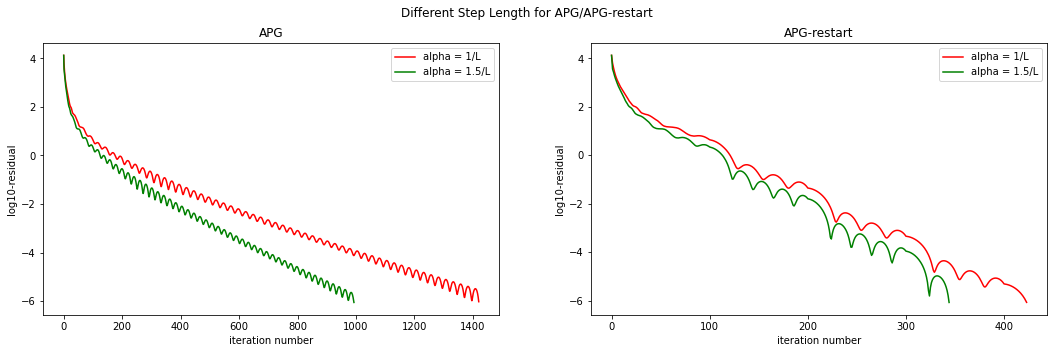

In [29]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Different Step Length for APG/APG-restart \n')
fig.set_size_inches(18, 5)

ax1.set_title('APG')
ax1.plot(np.log10(residual_record_apg_1[residual_record_apg_1!=0]), color = 'r', label='alpha = 1/L')
ax1.plot(np.log10(residual_record_apg_2[residual_record_apg_2!=0]), color = 'g', label='alpha = 1.5/L')
ax1.legend(loc = 'upper right')

ax1.set_xlabel('iteration number')
ax1.set_ylabel('log10-residual')

ax2.set_title('APG-restart')
ax2.plot(np.log10(residual_record_apg_restart_1[residual_record_apg_restart_1!=0]), color = 'r', label='alpha = 1/L')
ax2.plot(np.log10(residual_record_apg_restart_2[residual_record_apg_restart_2!=0]), color = 'g', label='alpha = 1.5/L')
ax2.legend(loc = 'upper right')

ax2.set_xlabel('iteration number')
ax2.set_ylabel('log10-residual')

plt.show()


- same step-length alpha, different optimization method

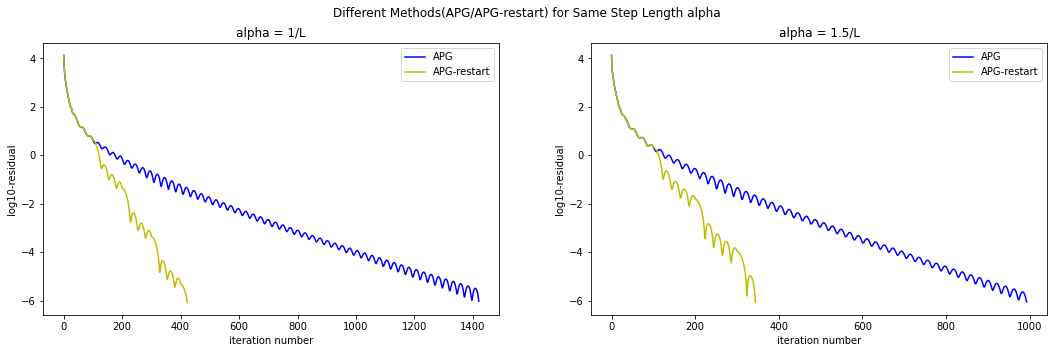

In [30]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Different Methods(APG/APG-restart) for Same Step Length alpha \n')
fig.set_size_inches(18, 5)

ax1.set_title('alpha = 1/L')
ax1.plot(np.log10(residual_record_apg_1[residual_record_apg_1!=0]), color = 'b', label='APG')
ax1.plot(np.log10(residual_record_apg_restart_1[residual_record_apg_restart_1!=0]), color = 'y', label='APG-restart')
ax1.legend(loc = 'upper right')

ax1.set_xlabel('iteration number')
ax1.set_ylabel('log10-residual')

ax2.set_title('alpha = 1.5/L')
ax2.plot(np.log10(residual_record_apg_2[residual_record_apg_2!=0]), color = 'b', label='APG')
ax2.plot(np.log10(residual_record_apg_restart_2[residual_record_apg_restart_2!=0]), color = 'y', label='APG-restart')
ax2.legend(loc = 'upper right')

ax2.set_xlabel('iteration number')
ax2.set_ylabel('log10-residual')

plt.show()


#### if we choose alpha = 3/L, then all algorithms will diverge
- the scale of beta will go to infinity
- with appropriate (large) size of step length, it can accelearte the convergence of beta
    - but if the step length is too large, the algorithm will diverge

In [31]:
alpha_3 = 3/L
max_iter = 300

In [32]:
# record beta_k-1
beta_apg_old = np.copy(beta_init)
# record beta_k
beta_apg_new = np.copy(beta_init)

## at most we iterate for 3000 times
residual_record_apg = np.zeros(max_iter)
time_record_apg = np.zeros(max_iter)

# record the momentum coefficient t
tk = [1, 1]

# Accelarated PG Algorithm
residual = np.linalg.norm(beta_apg_new - soft_threshold(beta_apg_new - np.matmul(X_std.T, np.matmul(X_std, beta_apg_new) - y), lamb), ord=2)

# 0-th iteration
k = 0

residual_record_apg[k], time_record_apg[k] = residual, 0

while residual > tol_comp:
    
    t.tic()
    if k == 0:
        hat_beta_apg = beta_apg_new
    else:
        hat_beta_apg = beta_apg_new + (tk[0] - 1)/ tk[1] * (beta_apg_new - beta_apg_old)
        
    
    delta = np.matmul(X_std, hat_beta_apg) - y
    beta_apg_old = beta_apg_new
    beta_apg_new = soft_threshold(hat_beta_apg - alpha_3 * np.matmul(X_std.T, delta), lamb * alpha_3)
   
    time = t.tocvalue()
    
    residual = np.linalg.norm(beta_apg_new - soft_threshold(beta_apg_new - np.matmul(X_std.T, np.matmul(X_std, beta_apg_new) - y), lamb), ord=2)
    
    k = k + 1
    residual_record_apg[k], time_record_apg[k] = residual, time + time_record_apg[k-1]
    
    print('Achieving beta({number})'.format(number = k))
    print('Residual for beta({number}) is: {residual}\n'.format(number = k, residual = residual))
    
    # update t
    tk[0], tk[1] = tk[1], (1 + math.sqrt(1 + 4 * (tk[1]**2) )) / 2
    
    # at most we have 3000 iteration
    if k >= max_iter - 1:
        break  

Achieving beta(1)
Residual for beta(1) is: 1128.4186971620288

Achieving beta(2)
Residual for beta(2) is: 5923.763211415021

Achieving beta(3)
Residual for beta(3) is: 702.0284469187878

Achieving beta(4)
Residual for beta(4) is: 5028.890808983163

Achieving beta(5)
Residual for beta(5) is: 1914.8218072342092

Achieving beta(6)
Residual for beta(6) is: 7438.044669067935

Achieving beta(7)
Residual for beta(7) is: 12505.352362357109

Achieving beta(8)
Residual for beta(8) is: 39201.79526512052

Achieving beta(9)
Residual for beta(9) is: 128431.29242800914

Achieving beta(10)
Residual for beta(10) is: 444698.82169699034

Achieving beta(11)
Residual for beta(11) is: 1580345.206602212

Achieving beta(12)
Residual for beta(12) is: 5737602.1836212585

Achieving beta(13)
Residual for beta(13) is: 21199885.124334052

Achieving beta(14)
Residual for beta(14) is: 79475180.43606511

Achieving beta(15)
Residual for beta(15) is: 301573106.76619756

Achieving beta(16)
Residual for beta(16) is: 11562

Achieving beta(140)
Residual for beta(140) is: 4.865930907766974e+87

Achieving beta(141)
Residual for beta(141) is: 2.1423541081100132e+88

Achieving beta(142)
Residual for beta(142) is: 9.432992511413213e+88

Achieving beta(143)
Residual for beta(143) is: 4.1537480212555017e+89

Achieving beta(144)
Residual for beta(144) is: 1.8292065659114595e+90

Achieving beta(145)
Residual for beta(145) is: 8.055951355170303e+90

Achieving beta(146)
Residual for beta(146) is: 3.5481497542681316e+91

Achieving beta(147)
Residual for beta(147) is: 1.5628511789704638e+92

Achieving beta(148)
Residual for beta(148) is: 6.88435803645851e+92

Achieving beta(149)
Residual for beta(149) is: 3.0327665907595283e+93

Achieving beta(150)
Residual for beta(150) is: 1.3361149499950768e+94

Achieving beta(151)
Residual for beta(151) is: 5.886776528105358e+94

Achieving beta(152)
Residual for beta(152) is: 2.5938195954811938e+95

Achieving beta(153)
Residual for beta(153) is: 1.1429575086836926e+96

Achieving be

Achieving beta(259)
Residual for beta(259) is: 2.755313928276929e+164

Achieving beta(260)
Residual for beta(260) is: 1.2189848998934285e+165

Achieving beta(261)
Residual for beta(261) is: 5.393057220992129e+165

Achieving beta(262)
Residual for beta(262) is: 2.386058693412427e+166

Achieving beta(263)
Residual for beta(263) is: 1.0556903143876692e+167

Achieving beta(264)
Residual for beta(264) is: 4.67090679654693e+167

Achieving beta(265)
Residual for beta(265) is: 2.0666886090067205e+168

Achieving beta(266)
Residual for beta(266) is: 9.144458662260174e+168

Achieving beta(267)
Residual for beta(267) is: 4.046224719006253e+169

Achieving beta(268)
Residual for beta(268) is: 1.790403722041794e+170

Achieving beta(269)
Residual for beta(269) is: 7.922474565817614e+170

Achieving beta(270)
Residual for beta(270) is: 3.5057389812440367e+171

Achieving beta(271)
Residual for beta(271) is: 1.5513403160868226e+172

Achieving beta(272)
Residual for beta(272) is: 6.865043494922416e+172

Ac

In [33]:
# record beta_k-1
beta_apg_old_restart = np.copy(beta_init)
# record beta_k
beta_apg_new_restart = np.copy(beta_init)

## at most we iterate for 3000 times
residual_record_apg_restart = np.zeros(max_iter)
time_record_apg_restart = np.zeros(max_iter)

# record the momentum coefficient t
tk = [1, 1]

# restart time point
trigger = 0
restart = 100

# Accelarated PG Algorithm - restart
residual = np.linalg.norm(beta_apg_new_restart - soft_threshold(beta_apg_new_restart - np.matmul(X_std.T, np.matmul(X_std, beta_apg_new_restart) - y), lamb), ord=2)

# 0-th iteration
k = 0

residual_record_apg_restart[k], time_record_apg_restart[k] = residual, 0

while residual > tol_comp:
    
    t.tic()
    if trigger == 0:
        hat_beta_apg_restart = beta_apg_new_restart
    else:
        hat_beta_apg_restart = beta_apg_new_restart + (tk[0] - 1)/ tk[1] * (beta_apg_new_restart - beta_apg_old_restart)
        
    
    delta = np.matmul(X_std, hat_beta_apg_restart) - y
    beta_apg_old_restart = beta_apg_new_restart
    beta_apg_new_restart = soft_threshold(hat_beta_apg_restart - alpha_3 * np.matmul(X_std.T, delta), lamb * alpha_3)
   
    time = t.tocvalue()
    
    residual = np.linalg.norm(beta_apg_new_restart - soft_threshold(beta_apg_new_restart - np.matmul(X_std.T, np.matmul(X_std, beta_apg_new_restart) - y), lamb), ord=2)
    
    k = k + 1    
    residual_record_apg_restart[k], time_record_apg_restart[k] = residual, time + time_record_apg_restart[k-1]
    
    print('Achieving beta({number})'.format(number = k))
    print('Residual for beta({number}) is: {residual}\n'.format(number = k, residual = residual))
    
    trigger = trigger + 1
    # restart
    if trigger == restart:
        tk[0], tk[1] = 1, 1
        # reset trigger
        trigger = 0
    else:
        # update t
        tk[0], tk[1] = tk[1], (1 + math.sqrt(1 + 4 * (tk[1]**2) )) / 2
    
    # at most we have 3000 iteration
    if k >= max_iter - 1:
        break  

Achieving beta(1)
Residual for beta(1) is: 1128.4186971620288

Achieving beta(2)
Residual for beta(2) is: 5923.763211415021

Achieving beta(3)
Residual for beta(3) is: 702.0284469187878

Achieving beta(4)
Residual for beta(4) is: 5028.890808983163

Achieving beta(5)
Residual for beta(5) is: 1914.8218072342092

Achieving beta(6)
Residual for beta(6) is: 7438.044669067935

Achieving beta(7)
Residual for beta(7) is: 12505.352362357109

Achieving beta(8)
Residual for beta(8) is: 39201.79526512052

Achieving beta(9)
Residual for beta(9) is: 128431.29242800914

Achieving beta(10)
Residual for beta(10) is: 444698.82169699034

Achieving beta(11)
Residual for beta(11) is: 1580345.206602212

Achieving beta(12)
Residual for beta(12) is: 5737602.1836212585

Achieving beta(13)
Residual for beta(13) is: 21199885.124334052

Achieving beta(14)
Residual for beta(14) is: 79475180.43606511

Achieving beta(15)
Residual for beta(15) is: 301573106.76619756

Achieving beta(16)
Residual for beta(16) is: 11562

Achieving beta(141)
Residual for beta(141) is: 1.4791015029769462e+86

Achieving beta(142)
Residual for beta(142) is: 6.358059039932118e+86

Achieving beta(143)
Residual for beta(143) is: 2.735215028797346e+87

Achieving beta(144)
Residual for beta(144) is: 1.1775613849488446e+88

Achieving beta(145)
Residual for beta(145) is: 5.073254172568197e+88

Achieving beta(146)
Residual for beta(146) is: 2.1871944788368943e+89

Achieving beta(147)
Residual for beta(147) is: 9.435685537041423e+89

Achieving beta(148)
Residual for beta(148) is: 4.073175508844156e+90

Achieving beta(149)
Residual for beta(149) is: 1.7593628963032688e+91

Achieving beta(150)
Residual for beta(150) is: 7.60378895426634e+91

Achieving beta(151)
Residual for beta(151) is: 3.288117125280564e+92

Achieving beta(152)
Residual for beta(152) is: 1.4226495594115245e+93

Achieving beta(153)
Residual for beta(153) is: 6.158477520180531e+93

Achieving beta(154)
Residual for beta(154) is: 2.667260143617953e+94

Achieving beta(1

Achieving beta(262)
Residual for beta(262) is: 2.605245813886537e+161

Achieving beta(263)
Residual for beta(263) is: 1.1326620816845789e+162

Achieving beta(264)
Residual for beta(264) is: 4.926132839116426e+162

Achieving beta(265)
Residual for beta(265) is: 2.143193141144902e+163

Achieving beta(266)
Residual for beta(266) is: 9.327418847139701e+163

Achieving beta(267)
Residual for beta(267) is: 4.060713630161127e+164

Achieving beta(268)
Residual for beta(268) is: 1.7683974805124575e+165

Achieving beta(269)
Residual for beta(269) is: 7.703536619666855e+165

Achieving beta(270)
Residual for beta(270) is: 3.356830553429568e+166

Achieving beta(271)
Residual for beta(271) is: 1.4631677222323828e+167

Achieving beta(272)
Residual for beta(272) is: 6.379414138574421e+167

Achieving beta(273)
Residual for beta(273) is: 2.7821861236165403e+168

Achieving beta(274)
Residual for beta(274) is: 1.213688121790282e+169

Achieving beta(275)
Residual for beta(275) is: 5.295909126173623e+169

Ac